In [8]:
DEBUG = True
break_counter = 0

# 1.Acquire HUST dataset from source

In [ ]:
!wget https://data.mendeley.com/public-files/datasets/nsc7hnsg4s/files/5ca0ac3e-d598-4d07-8dcb-879aa047e98b/file_downloaded

# 2.Process and extract current, voltage, time and cycles

In [ ]:
!unzip file_downloaded

In [ ]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import random
from tqdm import tqdm
import numpy as np

base_path = 'our_data'
len(os.listdir(base_path)) #should be 77 cells

In [ ]:
filenames_without_pkl = [file.rstrip('.pkl') for file in os.listdir(base_path)]
print(filenames_without_pkl)

# 3 a.Calculate SoC, SoH, extract RUL for 80% of 1.1Ah, 70% of the maximum used capacity

In [ ]:
#Current Integration Equation
import scipy.integrate as integrate
def current_integration(initial_SOC,C_rated,I_bat,t_start,t_end):
    change_in_charge,_ = integrate.quad(lambda t:float(I_bat),float(t_start),float(t_end)) 
    #print("Change in Charge : ",change_in_charge)
    return float(initial_SOC) + 100.0/float(C_rated) * change_in_charge

In [ ]:
# Precompute constant
C_rated = 1100.0 * 3600

os.makedirs('plots/',exist_ok=True)
os.makedirs('csvs/',exist_ok=True)

for cycle_regimen in filenames_without_pkl:
    #cycle_regimen = random.choice(filenames_without_pkl)#'10-1'
    unpickled_df = pd.read_pickle(f'{base_path}/{cycle_regimen}.pkl')#,engine='pyarrow',dtype_backend='pyarrow')
    print(cycle_regimen)
    df = pd.DataFrame(unpickled_df[cycle_regimen])#,engine='pyarrow',dtype_backend='pyarrow')
    rul = unpickled_df[cycle_regimen]['rul']
    dq = unpickled_df[cycle_regimen]['dq']
    data = unpickled_df[cycle_regimen]['data']
    ### Faster Code ########

    # Prepare a list to store all DataFrames, so we only concatenate at the end
    df_list = []

    # Initialize the previous_last_time for cumulative time calculation
    previous_last_time = 0

    # Iterate over the data dictionary
    for cycle_number, cycle_data in data.items():
        df_data = pd.DataFrame(cycle_data)

        # Calculate cumulative time
        df_data['Time (s) cumu'] = df_data['Time (s)'] + previous_last_time

        # Add 'rul' and 'dq' columns directly without creating lists
        df_data['rul'] = rul[cycle_number]
        df_data['dq'] = dq[cycle_number]

        # Update the previous_last_time for the next cycle
        previous_last_time = df_data['Time (s) cumu'].iloc[-1]

        # Store the DataFrame in the list
        df_list.append(df_data)

    # Concatenate all DataFrames at once
    merge_df = pd.concat(df_list, ignore_index=True)

    # Sort only once if needed
    merge_df = merge_df.sort_values(by='Time (s) cumu', ascending=True).reset_index(drop=True)


    df = merge_df

    # Create a figure with 5 vertical subplots
    fig, axs = plt.subplots(5, 1, figsize=(8, 10), sharex=True)

    # Plot Current vs Time
    axs[0].plot(df['Time (s) cumu']/86400, df['Current (mA)'], color='blue')
    axs[0].set_ylabel('Current (mA)')
    axs[0].set_title('Current vs Time')

    # Plot Voltage vs Time
    axs[1].plot(df['Time (s) cumu']/86400, df['Voltage (V)'], color='orange')
    axs[1].set_ylabel('Voltage (V)')
    axs[1].set_title('Voltage vs Time')

    # Plot Capacity vs Time
    axs[2].plot(df['Time (s) cumu']/86400, df['Capacity (mAh)'], color='green')
    axs[2].set_ylabel('Capacity (mAh)')
    axs[2].set_title('Capacity vs Time')
    #axs[2].set_xlabel('Time (s)')

    # Plot RUL vs Time
    axs[3].plot(df['Time (s) cumu']/86400, df['rul'], color='red')
    axs[3].set_ylabel('RUL (time)')
    axs[3].set_title('RUL vs Time')
    #axs[3].set_xlabel('Time (s)')

    # Plot Capacity vs Time
    axs[4].plot(df['Time (s) cumu']/86400, df['dq'], color='yellow')
    axs[4].set_ylabel('dq')
    axs[4].set_title('dq vs Time')
    axs[4].set_xlabel('Time (days)')

    # Add some spacing between plots
    plt.tight_layout()

    # You can also specify the DPI (dots per inch) for better resolution
    plt.savefig('plots/'+cycle_regimen+'-full-plot.png', dpi=300)
    # Display the plots
    plt.show()


    df = merge_df#.copy()
    df = df[df['Cycle number']<11]

    # Create a figure with 5 vertical subplots
    fig, axs = plt.subplots(5, 1, figsize=(8, 10), sharex=True)

    # Plot Current vs Time
    axs[0].plot(df['Time (s) cumu']/86400, df['Current (mA)'], color='blue')
    axs[0].set_ylabel('Current (mA)')
    axs[0].set_title('Current vs Time')

    # Plot Voltage vs Time
    axs[1].plot(df['Time (s) cumu']/86400, df['Voltage (V)'], color='orange')
    axs[1].set_ylabel('Voltage (V)')
    axs[1].set_title('Voltage vs Time')

    # Plot Capacity vs Time
    axs[2].plot(df['Time (s) cumu']/86400, df['Capacity (mAh)'], color='green')
    axs[2].set_ylabel('Capacity (mAh)')
    axs[2].set_title('Capacity vs Time')
    #axs[2].set_xlabel('Time (s)')

    # Plot RUL vs Time
    axs[3].plot(df['Time (s) cumu']/86400, df['rul'], color='red')
    axs[3].set_ylabel('RUL (time)')
    axs[3].set_title('RUL vs Time')
    #axs[3].set_xlabel('Time (s)')

    # Plot Capacity vs Time
    axs[4].plot(df['Time (s) cumu']/86400, df['dq'], color='yellow')
    axs[4].set_ylabel('dq')
    axs[4].set_title('dq vs Time')
    axs[4].set_xlabel('Time (days)')

    # You can also specify the DPI (dots per inch) for better resolution
    plt.savefig('plots/'+cycle_regimen+'-first-10-plot.png', dpi=300)
    # Add some spacing between plots
    plt.tight_layout()

    # Display the plots
    plt.show()

    merge_df.loc[merge_df['Capacity (mAh)'] == 0, 'previous_SOC'] = 0
    
    # Temporary storage for the computed SOC values
    cc_soc_values = np.zeros(len(merge_df))
    
    # Process each group
    for _, group in tqdm(merge_df.groupby('Cycle number')):
        # Initialize variables
        soc_values = []
        initial_SOC = 0  # Assuming this starts at 0 for each group
    
        # Iterate over each row in the group
        t_end = group.iloc[0]['Time (s)']  # Set initial t_end to the first time value
    
        for i, row in group.iterrows():
            if row["previous_SOC"] == 0:
                # Reset SOC calculation at the start of a new cycle
                initial_SOC = row["previous_SOC"]
                I_bat = row['Current (mA)']
                t_start = row['Time (s)']
                t_end = t_start  # Initialize t_end for the first row
            else:
                # Use previous SOC and time values for the next row
                t_start = t_end
                t_end = row['Time (s)']
                I_bat = row['Current (mA)']
    
            # Calculate SOC
            SOC = current_integration(initial_SOC=initial_SOC, C_rated=C_rated, I_bat=I_bat, t_start=t_start, t_end=t_end)
    
            # Update the initial_SOC for the next iteration
            initial_SOC = SOC
    
            # Store the result
            soc_values.append(SOC)
    
        # Assign computed SOC values back to the original DataFrame using loc with index slicing
        cc_soc_values[group.index] = soc_values
    
    # Finally, assign all computed SOC values to the DataFrame column in a single operation
    merge_df["CC_SOC"] = cc_soc_values
    merge_df.to_csv('csvs/'+cycle_regimen+'.csv',index=False)
    if DEBUG:
        break_counter += 1
        if break_counter > 3:
            break_counter = 0
            break

In [ ]:
base_paths = 'csvs/'
original_files = [file.rstrip('.csv') for file in os.listdir(base_paths)]
os.makedirs('csv-summary/',exist_ok=True)
os.makedirs('capacity-fade-cno-plot/',exist_ok=True)
os.makedirs('capacity-fade-time-plot/',exist_ok=True)
os.makedirs('SoH-cno-plot/',exist_ok=True)
for file in tqdm(original_files):
    df_sample = pd.read_csv(base_paths+file+'.csv')
    
    cycle_data_list = []
    
    for cycle_number, group in tqdm(df_sample.groupby('Cycle number')):
        cycle_data = {
            'Time (s) cumu':group['Time (s) cumu'].max(),
            'Cycle number': cycle_number,
            'max_SOC': group['CC_SOC'].max(),
            'min_SOC': group['CC_SOC'].min(),
            'SoH' : (abs(group['CC_SOC'].max()) + abs(group['CC_SOC'].min()))/115, #normalize SoH by 115 to obtain values between 1 and 0.
            'max_voltage': group['Voltage (V)'].max(),
            'min_voltage': group['Voltage (V)'].min(),
            'mean_voltage': group['Voltage (V)'].mean(),
            'max_current': group['Current (mA)'].max(),
            'min_current': group['Current (mA)'].min(),
            'timetaken': group['Time (s)'].max() - group['Time (s)'].min(),
            'max_capacity': group['Capacity (mAh)'].max(),
            'min_capacity': group['Capacity (mAh)'].min(),
            'rul': int(group['rul'].mean()),  # Replace with your RUL calculation function
            #'Time (s) cumu':
        }
        cycle_data_list.append(cycle_data)
        
    df_cycle_data = pd.DataFrame(cycle_data_list)
    df_cycle_data['max_capacity_fade_rate'] = -(df_cycle_data['max_capacity'].diff() / df_cycle_data['Cycle number'].diff())

    df_cycle_data.to_csv('csv-summary/'+file+'.csv',index=False)
    
    # Create a figure with 5 vertical subplots
    plt.plot(df_cycle_data['Cycle number'], df_cycle_data['SoH'])
    
    # Add labels and title
    plt.xlabel('Cycle number')
    plt.ylabel('SoH')
    plt.title('SoH per Cycle number')
    
    # Add some spacing between plots
    plt.tight_layout()
    
    # You can also specify the DPI (dots per inch) for better resolution
    plt.savefig('SoH-cno-plot/'+file+'.png', dpi=300)
    # Display the plots
    plt.show()
    # Plot the line against time
    plt.plot(df_cycle_data['Cycle number'], df_cycle_data['max_SOC'])
    
    # Add labels and title
    plt.xlabel('Cycle number')
    plt.ylabel('Max % of initial capacity')
    plt.title('Max Capacity per Cycle number')
    
    # Add some spacing between plots
    plt.tight_layout()
    
    # You can also specify the DPI (dots per inch) for better resolution
    plt.savefig('capacity-fade-cno-plot/'+file+'.png', dpi=300)
    # Display the plots
    plt.show()

    # Create a figure with 5 vertical subplots
    # Plot the line against time
    plt.plot(df_cycle_data['Time (s) cumu'], df_cycle_data['max_SOC'])
    
    # Add labels and title
    plt.xlabel('Time (s) cumu')
    plt.ylabel('Max % of initial capacity')
    plt.title('Max Capacity per end of cycle in time')
    
    # Display the plot
    plt.show()
    # You can also specify the DPI (dots per inch) for better resolution
    plt.savefig('capacity-fade-time-plot/'+file+'.png', dpi=300)
    # Display the plots
    plt.show()
    if DEBUG:
        break_counter += 1
        if break_counter > 3:
            break_counter = 0
            break

# 3 b. Compute Gompertz parameters k,a and b

In [ ]:
import random
choice = random.choice(original_files)
df = pd.read_csv("csv-summary/"+f'{choice}.csv')
df.head()

In [ ]:
dataframes = df

# Create figure with subplots
fig = plt.figure()

plt.plot(df['Cycle number']/10000, ((df['SoH'])), label=f"Bat {choice}")

plt.xlabel('Cycle number')
plt.ylabel('SoH')
plt.title(f'HUST Battery {choice} Capacity Fade')

plt.tight_layout()
plt.show()

In [ ]:
from matplotlib.gridspec import GridSpec

summary_path = 'csv-summary/'
files = os.listdir(summary_path)
print(files)
try:
    files.remove('1-8.csv')
except Exception as e:
    print(e)
# List of dataframes to plot
dataframes = [pd.read_csv(summary_path+file) for file in sorted(files)]
labels = [f'Battery {i+1}' for i in range(len(dataframes))]

# Create figure with subplots
fig = plt.figure(figsize=(10, 8))
gs = GridSpec(2, 1, height_ratios=[3, 1])  # Allocate space for the legend below

# Main plot on the first row
ax_main = fig.add_subplot(gs[0])
for i, df in enumerate(dataframes):
    ax_main.plot(df['Cycle number']/10000, df['SoH'], label=labels[i],color='blue')

# Set labels and title for the main plot
ax_main.set_xlabel('Normalized Cycle Number (x)')
ax_main.set_ylabel('SoH (y)')
ax_main.set_title('HUST Battery Capacity Fades')

plt.tight_layout()
plt.show()

In [ ]:
summary_path = 'csv-summary/'
files = os.listdir(summary_path)
print(files)
try:
    files.remove('1-8.csv')
except Exception as e:
    print(e)
# List of dataframes to plot
dataframes = [pd.read_csv(summary_path+file) for file in sorted(files)]
labels = [f'Battery {i+1}' for i in range(len(dataframes))]

# Create figure with subplots
fig = plt.figure(figsize=(10, 8))
gs = GridSpec(2, 1, height_ratios=[3, 1])  # Allocate space for the legend below

# Main plot on the first row
ax_main = fig.add_subplot(gs[0])
for i, df in enumerate(dataframes):
    ax_main.plot(df['Cycle number'], df['SoH'], label=labels[i],color='blue')

# Set labels and title for the main plot
ax_main.set_xlabel('Cycle number (x)')
ax_main.set_ylabel('SoH (y)')
ax_main.set_title('HUST Battery Capacity Fades')

plt.tight_layout()
plt.show()

In [ ]:
# Create figure with subplots
fig = plt.figure(figsize=(10, 8))
gs = GridSpec(2, 1, height_ratios=[3, 1])

# Main plot on the first row
ax_main = fig.add_subplot(gs[0])

# Variable to track the absolute lowest value seen across all dataframes
global_min_y = float('inf')
global_max_y = 0.0
for i, df in enumerate(dataframes):
    # Calculate x and y data
    x_val = df['Cycle number'] / 10000
    y_val = df['SoH']
    
    # Plot the curve
    ax_main.plot(x_val, y_val, color='blue')
    
    # --- ADDITION 1: Line for the last value of THIS curve ---
    last_y = y_val.iloc[-1]
    # Plots a dashed red line at the level of the last point
    #ax_main.axhline(y=last_y, color='red', linestyle='-', alpha=0.5, linewidth=1)
    
    # Check for global min
    current_min = y_val.min()
    if current_min < global_min_y:
        global_min_y = current_min
    current_max = y_val.min()
    if current_max > global_max_y:
        global_max_y = current_max
# --- ADDITION 2: Line for the LOWEST overall value ---
#ax_main.axhline(y=global_max_y, color='red', linestyle='-', alpha=0.5, linewidth=1)
# Plots a solid black line at the lowest point found in all data
ax_main.axhline(y=global_max_y, color='black', linestyle='-', linewidth=2, label=f'Global Min = {global_max_y:.4f}')

# Set labels and title for the main plot
ax_main.set_xlabel('Cycle number (x)')
ax_main.set_ylabel('SoH (y)')
ax_main.set_title('HUST Battery Capacity Fades')

# Add a legend to explain the black line
ax_main.legend()

plt.tight_layout()
plt.show()

# 3 c. Compute Gompertz parameters k,a and b

In [ ]:
csvs = os.listdir('csv-summary')
def gompertz_func(x,k,a,b):
    return k*np.exp(-np.exp(a-(b*x)))

In [ ]:
from scipy.optimize import minimize

In [ ]:
csv_choosen = random.choice(csvs)

df = pd.read_csv("csv-summary/"+csv_choosen)

x_data = np.array(df['Cycle number']/10000) # Independent variable
d_data = np.array(((df['SoH']))) # Observed dependent variable

# Define the loss function
def loss_function(params, x, d):
    k , a, b = params  # Parameters to optimize
    predicted_d = gompertz_func(x,k,a,b) # Equation model
    return np.sum((predicted_d - d) ** 2)  # Minimize squared error

# Initial guess for a, b, c
initial_guess = [1, 1, 1]

# Perform optimization
result = minimize(loss_function, initial_guess, args=(x_data, d_data))

# Optimized values of a, b, c
op_k, op_a, op_b = result.x
print(csv_choosen)
print(f"k = {op_k}, a = {op_a}, b = {op_b}")
print(f"The Gompertz value : {gompertz_func(x=x_data,k=op_k,a=op_a,b=op_b)}")

In [ ]:
data= []
for csv_choosen in csvs:
    
    df = pd.read_csv("csv-summary/"+csv_choosen)
    ## Independent variable
    x_data = np.array(df['Cycle number']/10000)    # Independent variable

    d_data = np.array(((df['SoH'])))   # Observed dependent variable
    # normalization was (df['SoH'].max()-80), using 115 to standardize all cells
    # Define the loss function
    def loss_function(params, x, d):
        k , a, b = params  # Parameters to optimize
        predicted_d = gompertz_func(x,k,a,b) # Equation model
        return np.sum((predicted_d - d) ** 2)  # Minimize squared error
    
    # Initial guess for a, b, c
    initial_guess = [1, 1, 1]
    
    # Perform optimization
    result = minimize(loss_function, initial_guess, args=(x_data, d_data))
    
    # Optimized values of a, b, c
    op_k, op_a, op_b = result.x
    #print(csv_choosen)
    #print(f"k = {op_k}, a = {op_a}, b = {op_b}")
    data.append({'file':csv_choosen,'k':op_k,'a':op_a,'b':op_b,'rul':len(df['Cycle number']),'SoH_above_80':(df['SoH'].max()-0.80),'SoH':(df['SoH'].max()),'norm_SoH':((df['SoH'].max()))})

gompertz_df = pd.DataFrame(data)

gompertz_df.to_csv('hust_gompertz_params.csv', index=False)  

gompertz_df.head()

In [ ]:
gompertz_df['gompertz-value'] = gompertz_func(x=gompertz_df['rul']/10000,k=gompertz_df['k'],a=gompertz_df['a'],b=gompertz_df['b'])
gompertz_df['gompertz-1st-derivative-value']=gompertz_df['b']*gompertz_func(x=gompertz_df['rul']/10000,k=gompertz_df['k'],a=gompertz_df['a'],b=gompertz_df['b'])*np.exp(gompertz_df['a'] - (gompertz_df['b'] * gompertz_df['rul']/10000))
gompertz_df['gompertz-2nd-derivative-value']=gompertz_df['b']**2*gompertz_func(x=gompertz_df['rul']/10000,k=gompertz_df['k'],a=gompertz_df['a'],b=gompertz_df['b'])*np.exp(gompertz_df['a'] - (gompertz_df['b'] * gompertz_df['rul']/10000))*(np.exp(gompertz_df['a'] - (gompertz_df['b'] * gompertz_df['rul']/10000)-1))

In [ ]:
gompertz_df = gompertz_df.sort_values(by='rul').reset_index(drop=True)

In [ ]:
gompertz_df['gompertz-value'].plot()

In [ ]:
gompertz_df['gompertz-1st-derivative-value'].plot()

In [ ]:
gompertz_df['gompertz-2nd-derivative-value'].plot()

In [ ]:
gompertz_df.iloc[:,1:].corr()

# 3 d. Visualize Gompertz parameters k,a and b & battery values

In [ ]:
bins = [1000, 1500, 2000, 4000]
labels = ['>1000', '>1500', '>2000']

# 3. Create the Category Column
# right=False ensures 2000 falls into '2000s', not '1000s'
gompertz_df['rul_category'] = pd.cut(gompertz_df['rul'], bins=bins, labels=labels, right=False)

In [ ]:
# 4. Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot A: How many items are in each batch? (Bar Chart)
counts = gompertz_df['rul_category'].value_counts().sort_index()
counts.plot(kind='bar', ax=axes[0], color='skyblue', edgecolor='black')
axes[0].set_title('Count of Values per Batch')
axes[0].set_ylabel('Frequency')
axes[0].set_xlabel('RUL Category')
# Plot B: What are the values inside each batch? (Box Plot)
gompertz_df.boxplot(column='rul', by='rul_category', ax=axes[1], grid=False)
axes[1].set_title('Distribution of Values by Batch')
axes[1].set_ylabel('Actual Value')
axes[1].set_xlabel('RUL Category')
plt.suptitle('') # Clean up default pandas title

plt.tight_layout()
plt.savefig('category_plots.png')
plt.show()

In [ ]:
gompertz_df['>=2000 rul'] = gompertz_df['rul'] >= 2000

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Example data
x = np.array(gompertz_df['a'])
y = np.array(gompertz_df['b'])
z = np.array(gompertz_df['k'])
binary_values = np.array(gompertz_df['>=2000 rul'])  # Binary column

# Map True/False to colors
colors = np.where(binary_values, 'blue', 'red')  # True = blue, False = red

# Create a 3D figure
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot points with discrete colors
sc = ax.scatter(x, y, z, c=colors, s=50)

# Labels
ax.set_xlabel("a")
ax.set_ylabel("b")
ax.set_zlabel("k")

# Add a legend manually
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', label='True', markersize=8, markerfacecolor='blue'),
                   Line2D([0], [0], marker='o', color='w', label='False', markersize=8, markerfacecolor='red')]
ax.legend(handles=legend_elements, loc='best')

# Show the plot
plt.show()

In [ ]:
x = np.array(gompertz_df['a'])
y = np.array(gompertz_df['b'])
#z = np.array(gompertz_df['k'])
binary_values = np.array(gompertz_df['>=2000 rul'])  # Binary column

# Map True/False to colors
colors = np.where(binary_values, 'blue', 'red')  # True = blue, False = red

# Create 2D scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(x, y, c=colors, s=100, edgecolors='black')

# Labels
ax.set_xlabel("a")
ax.set_ylabel("b")
ax.set_title("2D Scatter Plot with Binary Coloring")#title("2D Scatter Plot with Binary Coloring")

# Add a legend manually
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', label='True', markersize=10, markerfacecolor='blue'),
                   Line2D([0], [0], marker='o', color='w', label='False', markersize=10, markerfacecolor='red')]

ax.legend(handles=legend_elements, loc='best')

# Show plot
plt.show()

In [ ]:
x = np.array(gompertz_df['a'])
y = np.array(gompertz_df['b'])
z = np.array(gompertz_df['k'])
binary_values = np.array(gompertz_df['>=2000 rul'])  # Binary column

# Map True/False to colors
colors = np.where(binary_values, 'blue', 'red')  # True = blue, False = red

# Create figure and subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Subplot 1: X vs Y
axes[0].scatter(x, y, c=colors, s=100, edgecolors='black')
axes[0].set_xlabel("a")
axes[0].set_ylabel("b")
axes[0].set_title("a vs b")

# Subplot 2: X vs Z
axes[1].scatter(x, z, c=colors, s=100, edgecolors='black')
axes[1].set_xlabel("a")
axes[1].set_ylabel("k")
axes[1].set_title("a vs k")

# Subplot 3: Y vs Z
axes[2].scatter(y, z, c=colors, s=100, edgecolors='black')
axes[2].set_xlabel("b")
axes[2].set_ylabel("k")
axes[2].set_title("b vs k")

# Add a legend manually (only in the first subplot)
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', label='True', markersize=10, markerfacecolor='blue'),
                   Line2D([0], [0], marker='o', color='w', label='False', markersize=10, markerfacecolor='red')]
axes[0].legend(handles=legend_elements, loc='best')

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
# 1. Define the pairs of columns you want to plot for each subplot
# Format: (subplot_index, x_column_name, y_column_name)
plot_pairs = [
    (0, 'a', 'b'),
    (1, 'a', 'k'),
    (2, 'b', 'k')
]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 2. Loop through each subplot configuration
for ax_idx, x_col, y_col in plot_pairs:
    ax = axes[ax_idx]
    
    # 3. Group by category and plot each chunk
    # This automatically assigns a different color to each category
    # 'observed=True' handles cases where some categories might be empty
    for name, group in gompertz_df.groupby('rul_category', observed=True):
        ax.scatter(
            group[x_col], 
            group[y_col], 
            label=name,         # Uses the category name for the legend
            s=100, 
            edgecolors='black', 
            alpha=0.7           # Adds transparency
        )

    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    ax.set_title(f"{x_col} vs {y_col}")

# 4. Add the legend (only needed on the first plot to avoid clutter)
axes[0].legend(title="RUL", loc='best')

plt.tight_layout()
plt.show()

In [ ]:
# 1. Define your specific colors here
# Keys must match the labels you created in pd.cut
color_map = {
    '>1000': 'red', 
    '>2000': 'blue', 
    '>1500': 'green'
}

# 2. Define the plot pairs (Subplot Index, X Col, Y Col)
plot_pairs = [
    (0, 'a', 'b'),
    (1, 'a', 'k'),
    (2, 'b', 'k')
]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax_idx, x_col, y_col in plot_pairs:
    ax = axes[ax_idx]
    
    # Group by category so we can control color per group
    for name, group in gompertz_df.groupby('rul_category', observed=True):
        
        # Select color based on the group name
        # .get(name, 'gray') is a fallback in case a category is missing from the map
        specific_color = color_map.get(name, 'gray')
        
        ax.scatter(
            group[x_col], 
            group[y_col], 
            label=name, 
            c=specific_color,      # <--- Apply the specific color here
            s=100, 
            edgecolors='black',    # Keep the black border for contrast
            alpha=0.7
        )

    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    ax.set_title(f"{x_col} vs {y_col}")

# Add legend
axes[0].legend(title="RUL", loc='best')

plt.tight_layout()
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# ... (Assume df is created as above)

plt.figure(figsize=(10, 6))

# The 'hue' parameter does exactly what you want automatically
sns.scatterplot(data=gompertz_df, x='a', y='b', hue='rul_category', palette=color_map, s=100)

plt.title("Automatic Coloring with Seaborn")
plt.show()

In [ ]:
# Compute the correlation matrix
corr_matrix = gompertz_df.iloc[:, 1:-2].corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("HUST Data Gompertz Params")
plt.show()

# 3 e. Compute gompertz parameters at multiple cycle intervals for gompertz model

In [ ]:
os.makedirs('gompertz-parameters-per-cycle/',exist_ok=True)
count = 0
for csv_choosen in csvs:
    data= []
    #csv_choosen = random.choice(csvs)
    
    df_full = pd.read_csv("csv-summary/"+csv_choosen)
    rul_value = len(df_full['Cycle number']) 
    print(rul_value)
    for i in range(1,rul_value+1):
        df = df_full.iloc[0:i]
        # Example dataset (x values and corresponding observed d values)
        # x_data = np.array(df['Cycle number']/len(df['Cycle number']))#df['Cycle number'].to_list()) #np.array([0,1, 2, 3, 4, 5])  # Independent variable
        x_data = np.array(df['Cycle number']/10000)#df['Cycle number'].to_list()) #np.array([0,1, 2, 3, 4, 5])  # Independent variable
    
        d_data = np.array((df['SoH']))#(df['SoH'].max()-80)))#df['max_SOC'].to_list())#np.array([1,2.7, 7.4, 20.1, 54.6, 148.4])  # Observed dependent variable
        
        # Define the loss function
        def loss_function(params, x, d):
            k , a, b = params  # Parameters to optimize
            predicted_d = gompertz_func(x,k,a,b) # Equation model
            return np.sum((predicted_d - d) ** 2)  # Minimize squared error
        
        # Initial guess for a, b, c
        initial_guess = [1, 1, 1]
        
        # Perform optimization
        result = minimize(loss_function, initial_guess, args=(x_data, d_data))
        
        # Optimized values of a, b, c
        op_k, op_a, op_b = result.x
        #print(csv_choosen)
        #print(f"k = {op_k}, a = {op_a}, b = {op_b}")
        data.append({'Cycle number':i,'k':op_k,'a':op_a,'b':op_b,'rul':rul_value-i+1,'max_SoC_above_80':(df['max_SOC'].max()-80),'SoH':df.loc[i-1,'SoH'],'gompertz-value': gompertz_func(x=(rul_value-i+1)/10000,k=op_k,a=op_a,b=op_b),'gompertz-1st-derivative-value':(op_b*gompertz_func(x=(rul_value-i+1)/10000,k=op_k,a=op_a,b=op_b)*np.exp(op_a - (op_b * (rul_value-i+1)/10000))),'gompertz-2nd-derivative-value':(op_b**2*gompertz_func(x=(rul_value-i+1)/10000,k=op_k,a=op_a,b=op_b)*np.exp(op_a - (op_b * (rul_value-i+1)/10000))*(np.exp(op_a - (op_b * (rul_value-i+1)/10000))-1))}) #,'simplified-gompertz-1st-derivative-value':(-1*op_b*gompertz_func(x=(rul_value-i+1)/10000,k=op_k,a=op_a,b=op_b)*np.log(gompertz_func(x=(rul_value-i+1)/10000,k=op_k,a=op_a,b=op_b)/op_k))
    
    gompertz_df = pd.DataFrame(data)
    
    gompertz_df.to_csv(f"gompertz-parameters-per-cycle/{csv_choosen.split('.')[0]}-hust_gompertz_params.csv", index=False)
    count += 1
    #break
    # if count == 4:
    #     break

In [ ]:
gompertz_df['SoH'].plot()

In [ ]:
gompertz_df['gompertz-value'].plot()

In [ ]:
gompertz_df['gompertz-1st-derivative-value'].plot()

In [ ]:
gompertz_df['gompertz-2nd-derivative-value'].plot()

# 4.  Visualize per cycle y, dy/dx and d2y/dx2

In [ ]:
import re

files = os.listdir("csv-summary")
#Filter out non-csv files, folders or csv that don't start with a digit

filtered = [f for f in files if re.match(r'^\d', f) and f.endswith('.csv')]

print(len(filtered))

pairs = [re.match(r'^(\d+-\d+)', f).group(1) for f in filtered]

print(pairs)

In [ ]:
base_path = 'gompertz-parameters-per-cycle/'

choice = random.choice(pairs)

gompertz_df_full = pd.read_csv(base_path+choice+"-hust_gompertz_params.csv")
print(gompertz_df_full.head())
# Plot multiple columns vs Time on one plot
y_columns = ["k","a","b"]#,'rul']#,"rul"]  # choose the columns to plot

for col in y_columns:
    # plt.plot(gompertz_df["cycle"], gompertz_df[col], label=col)
    plt.plot(gompertz_df_full["Cycle number"], gompertz_df_full[col], label=col)

plt.xlabel("cycle")
plt.ylabel("Values")
# Use log scale on y-axis (common in battery/fade plots)
#plt.yscale("log")
plt.title(f"Gompertz Parameter Data vs Cycle for HUST cell {choice}")
plt.legend()
plt.show()

In [ ]:
os.makedirs('Parameter-Plots/',exist_ok=True)
print(gompertz_df_full.tail())
# Plot multiple columns vs Time on one plot
y_columns = ["k","a","b"]#,'rul']#,"rul"]  # choose the columns to plot

for col in y_columns:
    # plt.plot(gompertz_df["cycle"], gompertz_df[col], label=col)
    plt.plot(gompertz_df_full["Cycle number"], gompertz_df_full[col], label=col)

plt.xlabel("Cycle Number")
plt.ylabel("Values")
# Use log scale on y-axis (common in battery/fade plots)
#plt.yscale("log")
plt.yscale('symlog', linthresh=1)
plt.title(f"Gompertz Parameter Data vs Cycle for HUST cell {choice}")
plt.legend()
plt.savefig(f"Parameter-Plots/HUST-cell-{choice}.png",dpi=300,format='png')
plt.show()

# Run check for the entire HUST dataset

In [40]:
import re
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

if DEBUG:
    files = os.listdir("/kaggle/input/hust-preprocessed-data/csv-summary")
    #Filter out non-csv files, folders or csv that don't start with a digit
    
    filtered = [f for f in files if re.match(r'^\d', f) and f.endswith('.csv')]
    
    print(len(filtered))
    
    pairs = [re.match(r'^(\d+-\d+)', f).group(1) for f in filtered]
    
    print(pairs)

77
['6-6', '7-8', '5-3', '6-8', '5-5', '2-4', '10-3', '1-4', '6-3', '5-6', '8-3', '3-6', '10-4', '9-6', '3-2', '9-2', '9-7', '6-5', '4-8', '5-7', '1-5', '1-7', '1-8', '8-7', '6-2', '3-3', '6-1', '2-7', '1-2', '10-7', '10-1', '9-1', '8-5', '9-4', '4-4', '3-4', '10-6', '5-2', '7-5', '4-3', '5-4', '3-5', '7-2', '3-7', '1-3', '9-5', '3-1', '4-1', '9-3', '7-1', '8-8', '6-4', '4-2', '5-1', '2-3', '4-5', '4-6', '2-8', '8-1', '10-8', '9-8', '3-8', '7-3', '8-2', '8-6', '7-6', '10-5', '7-7', '7-4', '4-7', '2-6', '10-2', '1-6', '8-4', '2-5', '1-1', '2-2']


In [13]:
cycle_lengths = []
cycle_lengths_sort = {}

if DEBUG:
    base_path = "/kaggle/input/hust-preprocessed-data/gompertz-parameters-per-cycle/"
#Correlation of k, a and b with cycle number
##Place k, a and b of all cells in all cycles in one dataframe
for choice in pairs:
    gompertz_df_full = pd.read_csv(base_path + choice + "-hust_gompertz_params.csv")
    cycle_lengths.append(gompertz_df_full.shape[0])
    cycle_lengths_sort[choice] = gompertz_df_full.shape[0]
print(f"Max : {max(cycle_lengths)}, Min : {min(cycle_lengths)}")


#sort pairs by RUL
pairs = sorted(cycle_lengths_sort, key=cycle_lengths_sort.get)
print(pairs)

Max : 2689, Min : 1142
['4-3', '1-6', '7-3', '8-1', '8-5', '4-6', '2-5', '7-4', '10-8', '7-6', '5-7', '2-8', '4-4', '2-4', '1-4', '1-1', '4-5', '2-6', '5-5', '6-1', '3-3', '1-7', '8-8', '7-7', '7-1', '10-2', '10-1', '4-8', '6-4', '9-6', '2-3', '3-4', '4-2', '10-7', '6-3', '10-4', '10-3', '1-3', '7-5', '8-4', '9-3', '6-2', '5-2', '7-8', '3-1', '5-4', '1-5', '9-4', '9-7', '7-2', '10-5', '8-2', '8-7', '9-1', '9-2', '9-5', '6-5', '2-7', '4-7', '4-1', '3-2', '1-8', '10-6', '8-3', '9-8', '3-8', '8-6', '6-8', '5-6', '6-6', '3-7', '3-6', '5-1', '2-2', '3-5', '1-2', '5-3']


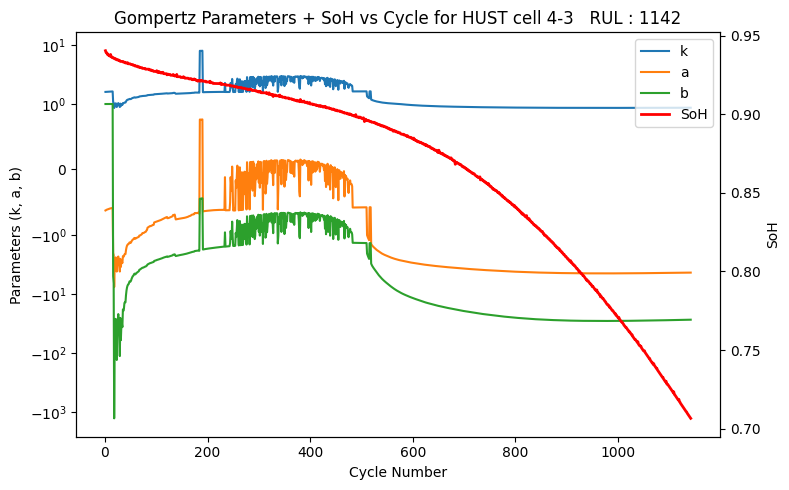

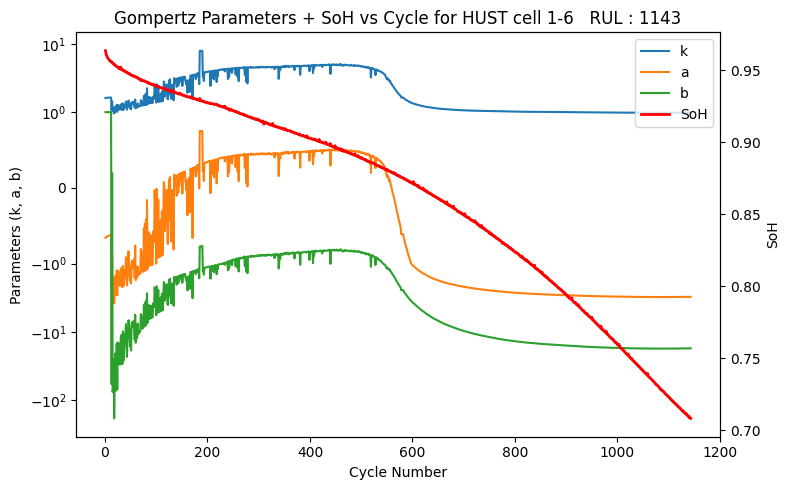

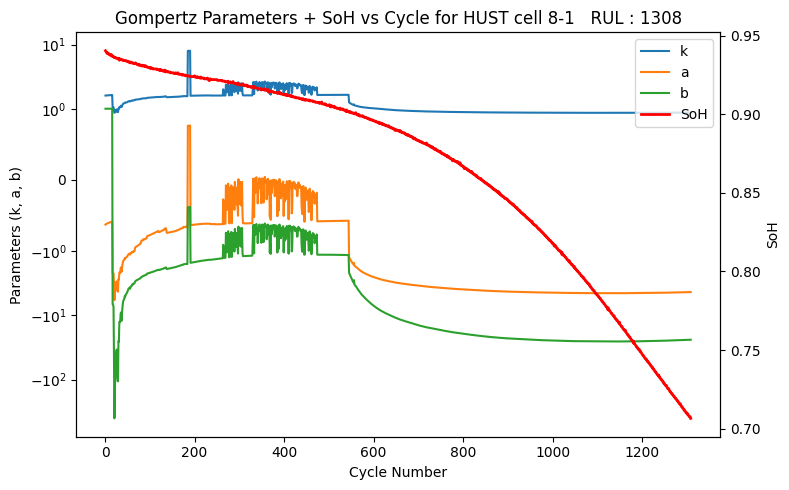

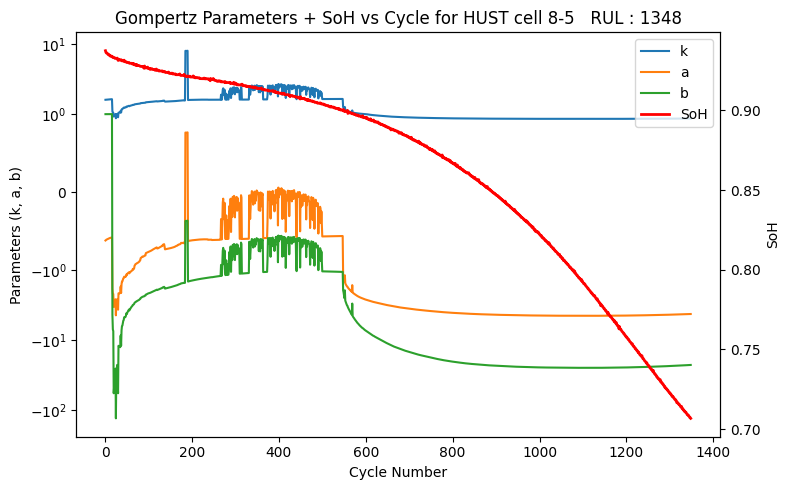

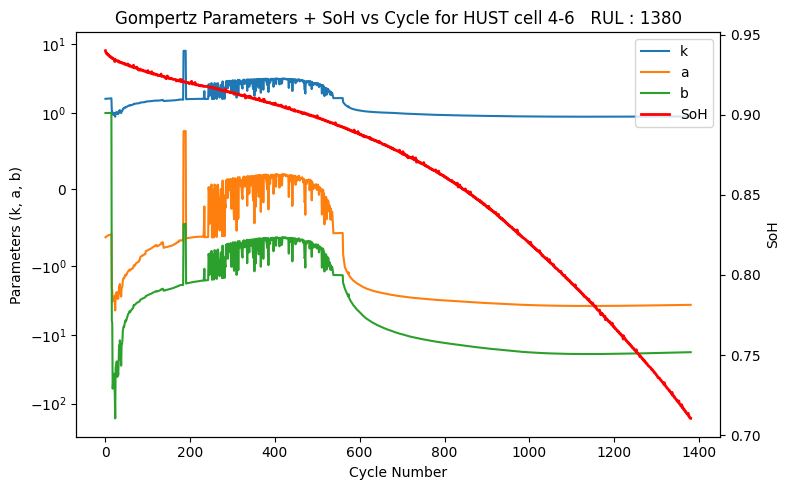

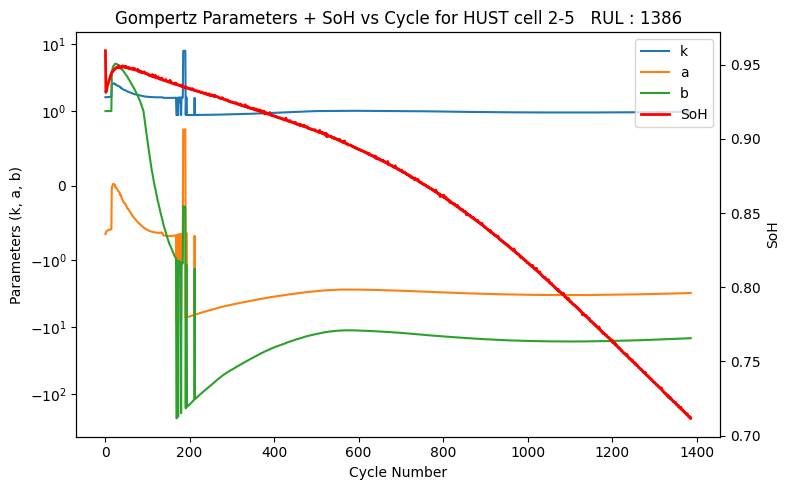

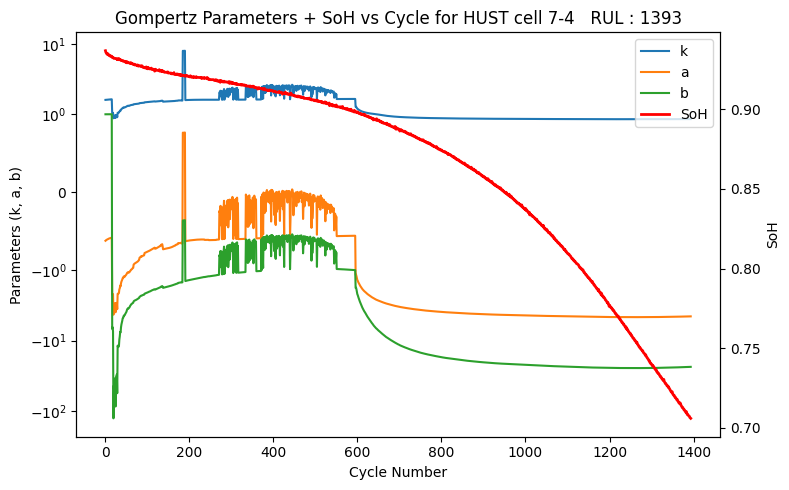

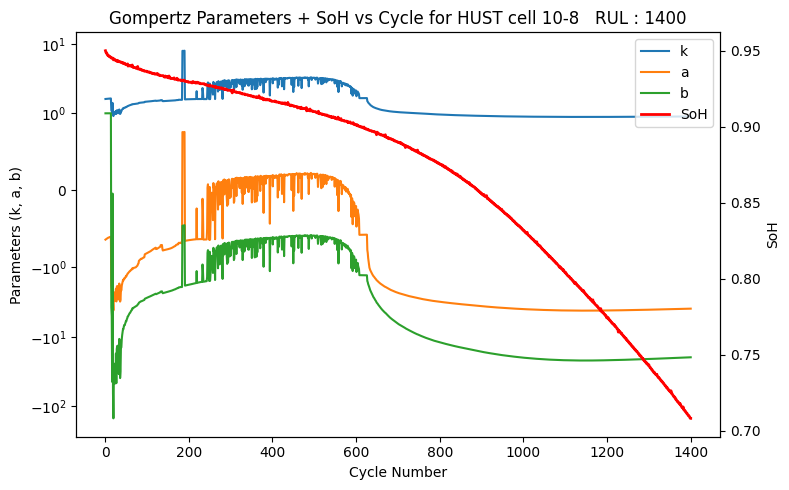

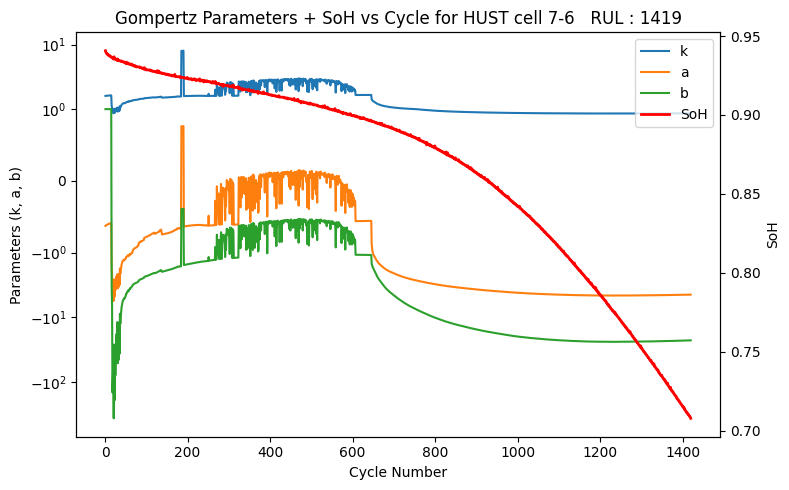

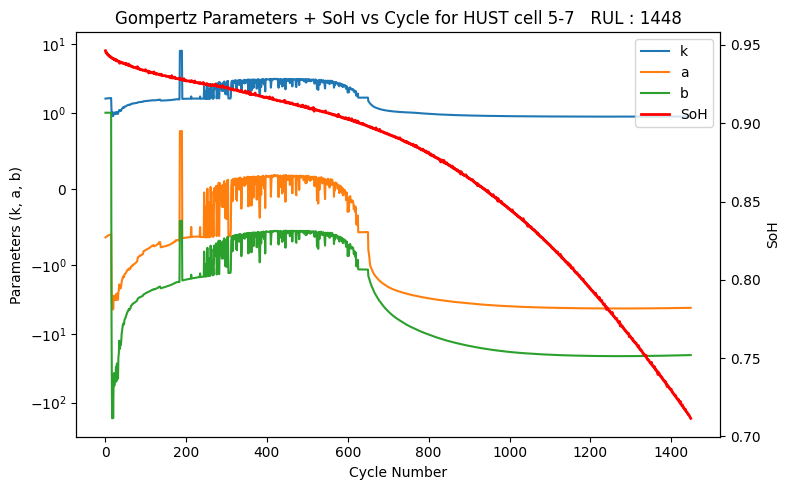

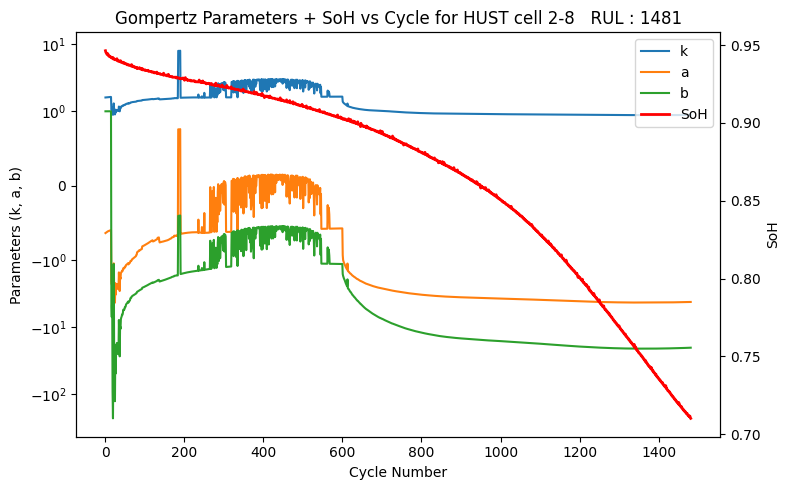

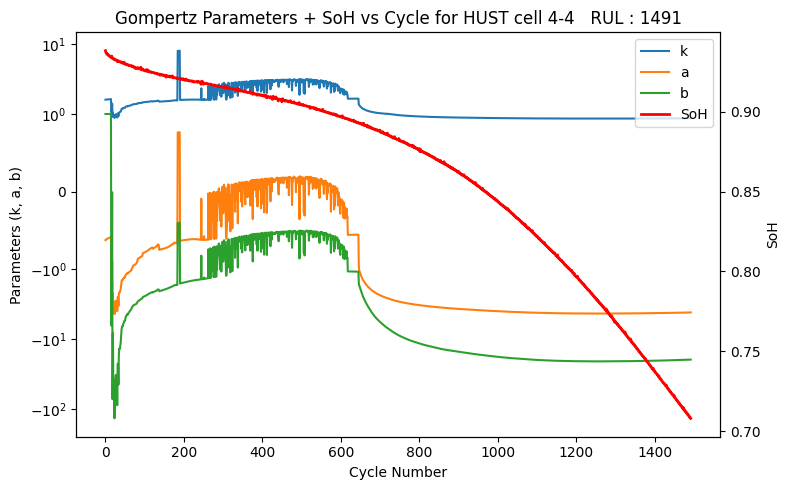

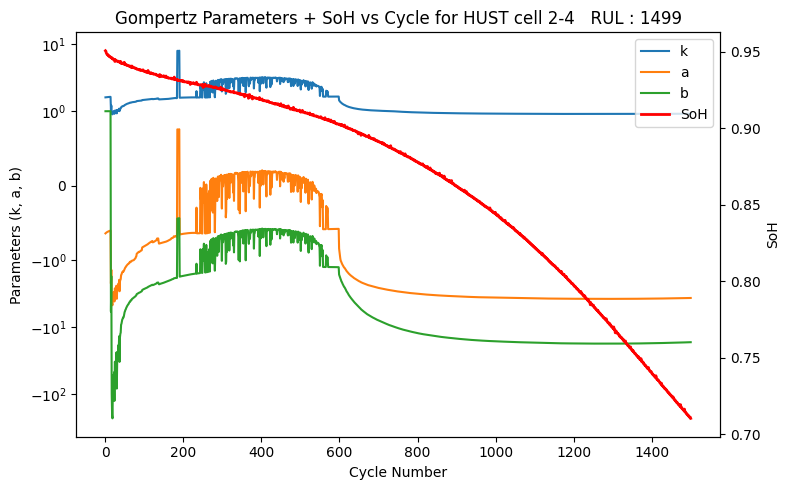

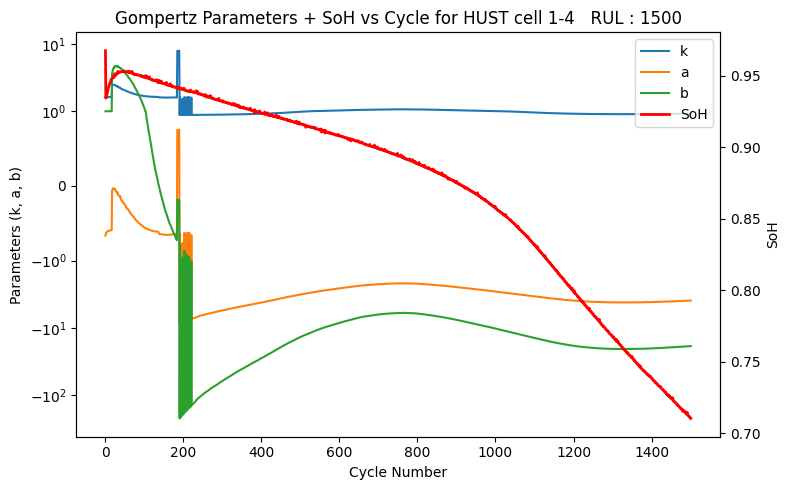

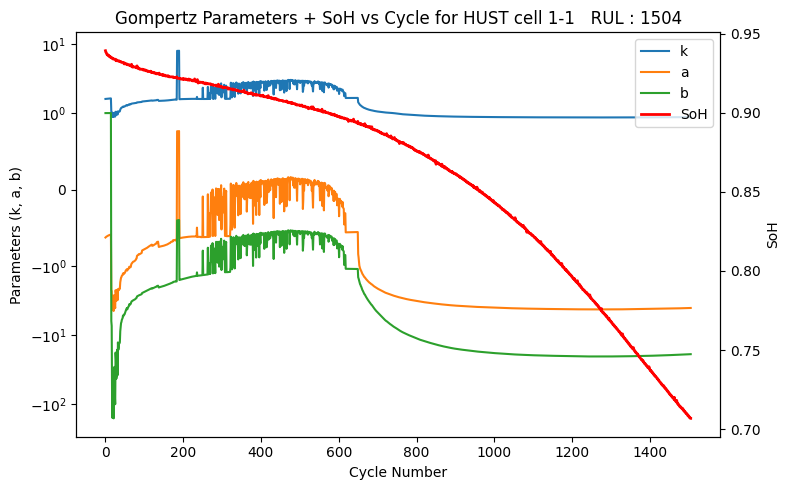

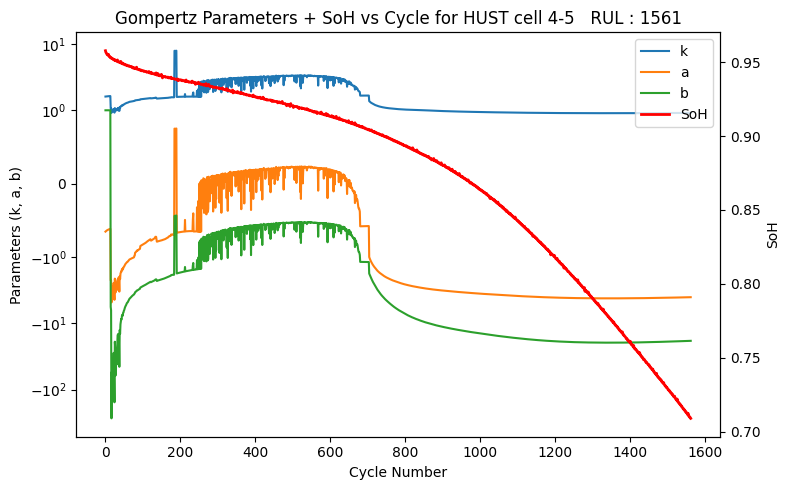

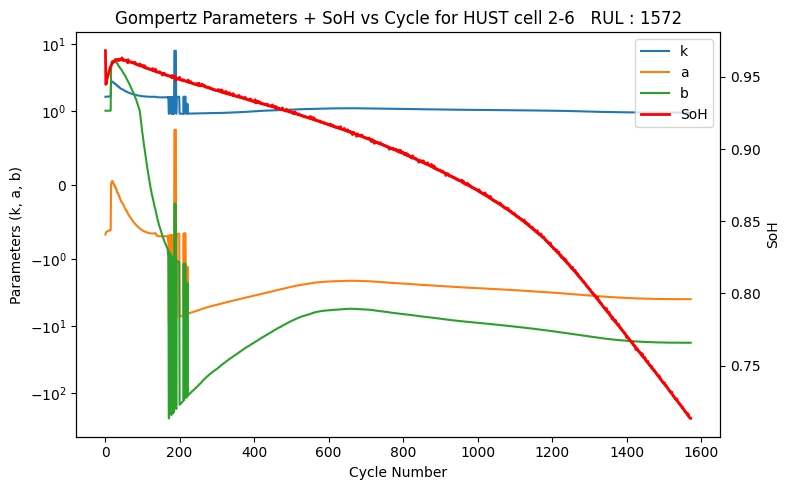

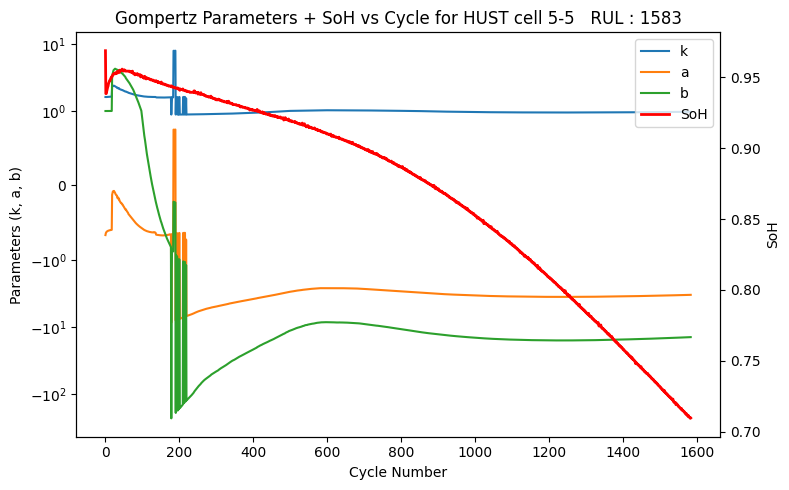

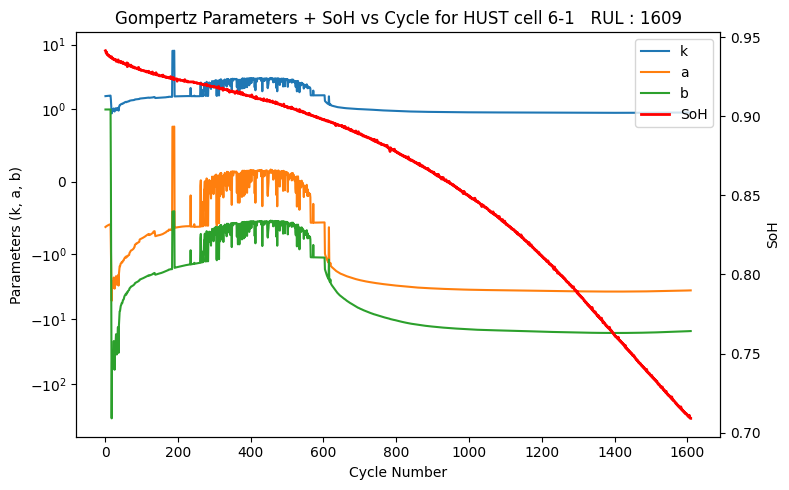

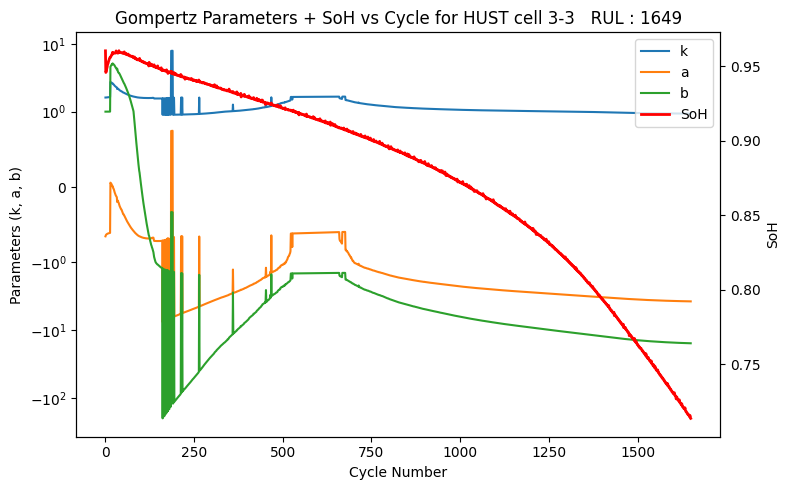

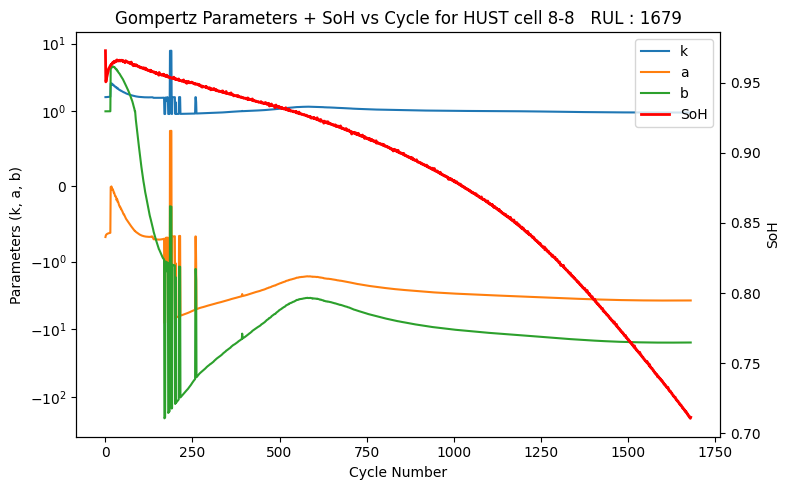

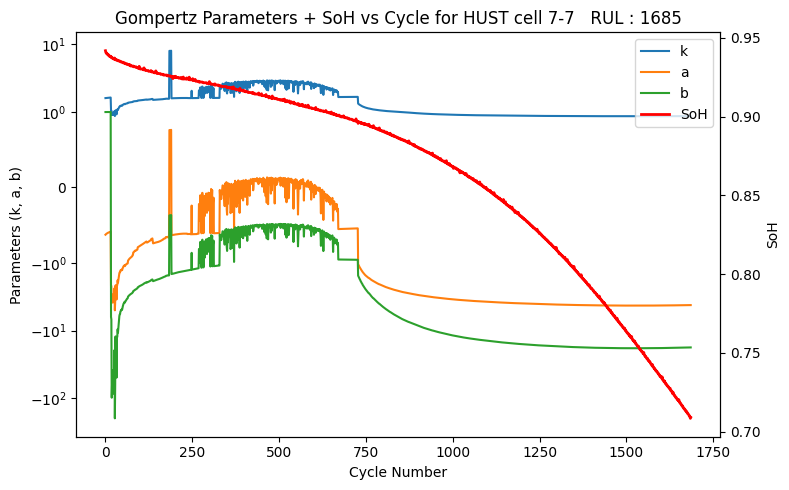

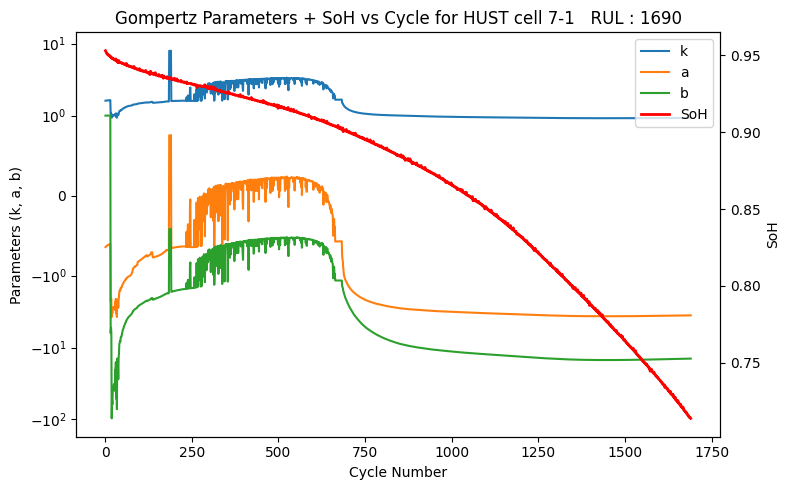

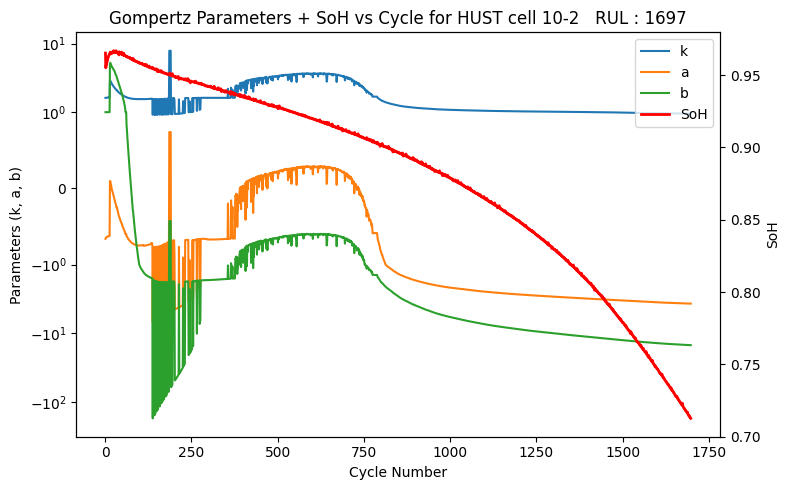

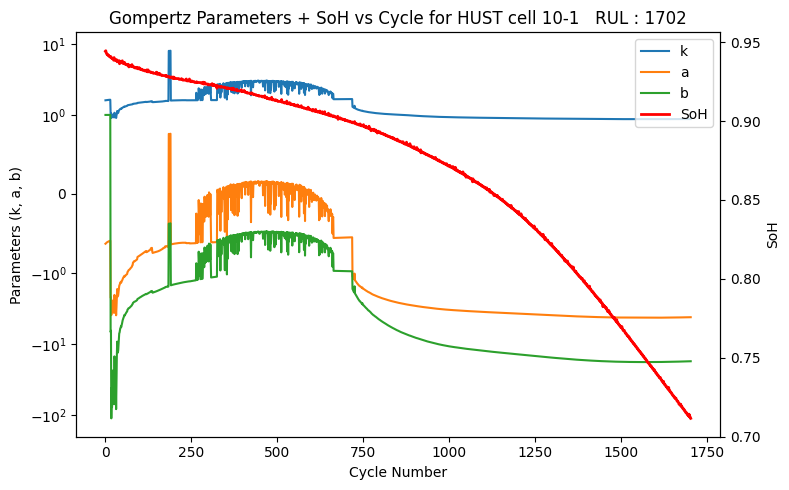

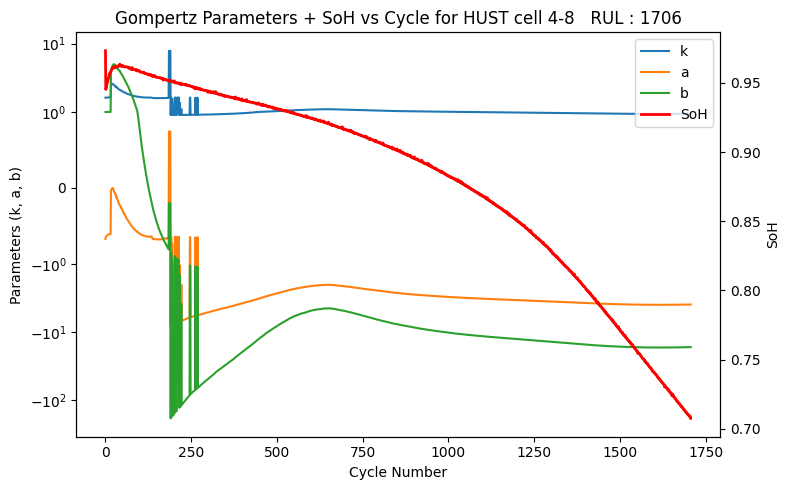

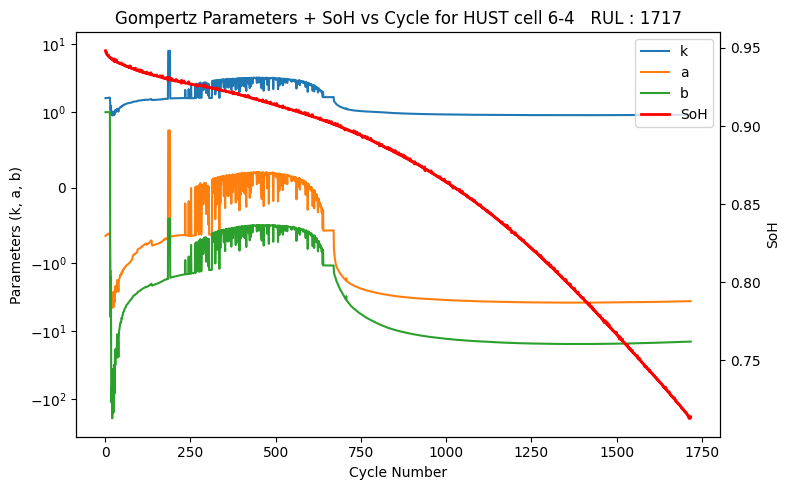

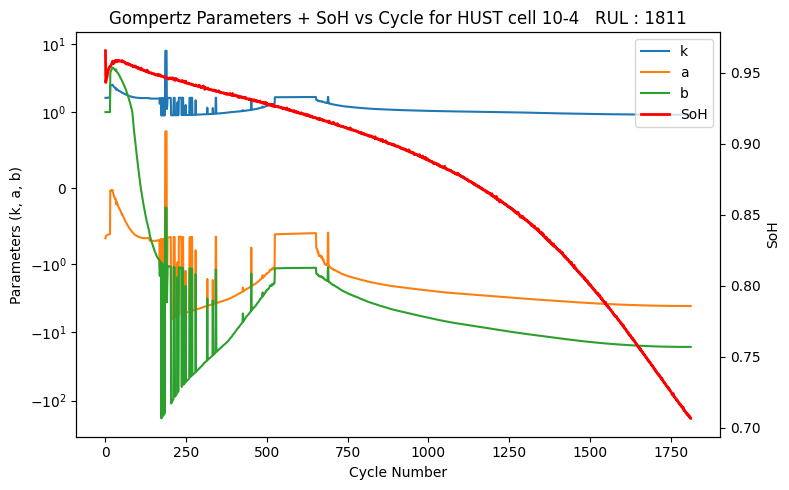

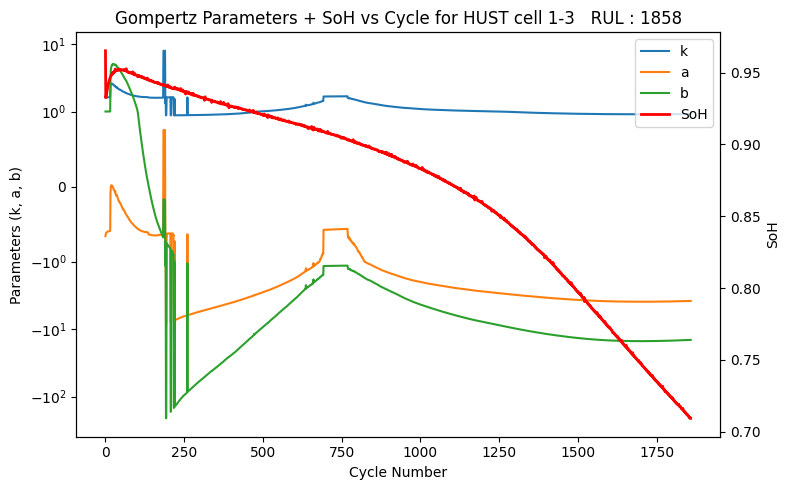

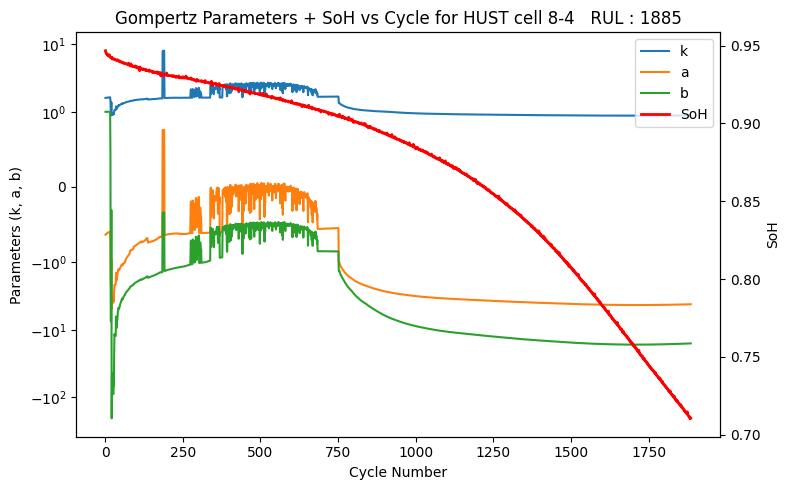

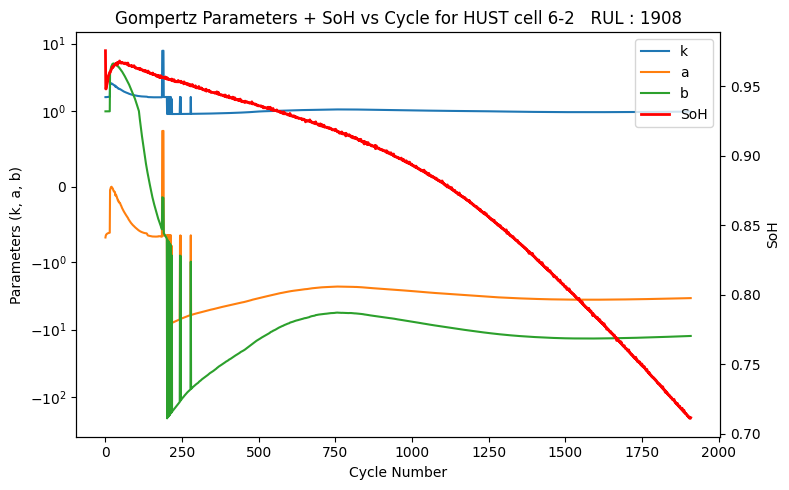

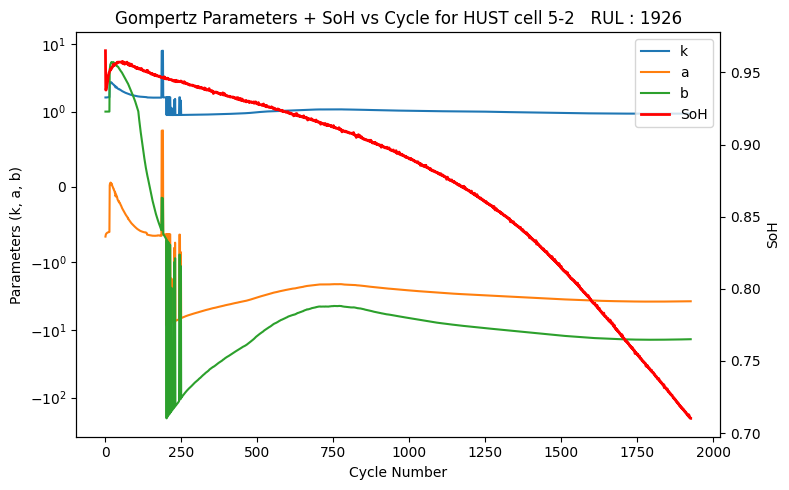

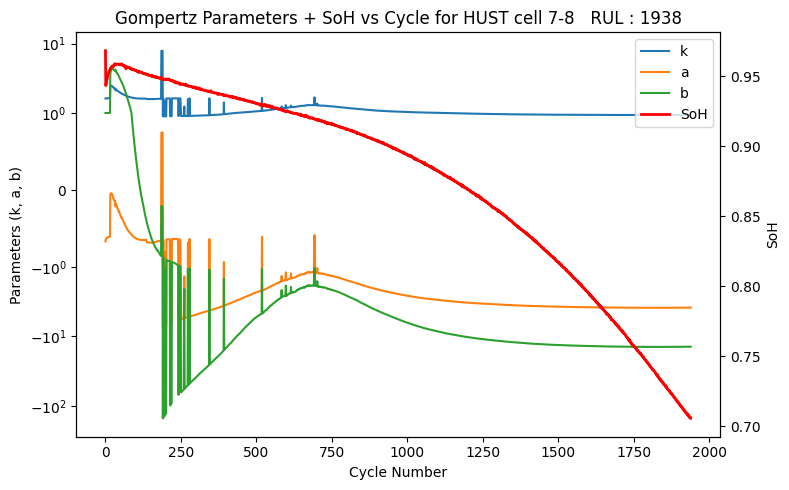

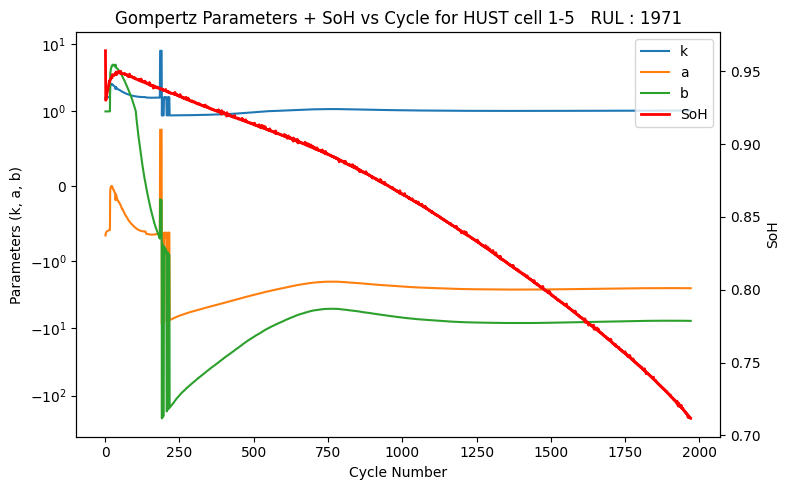

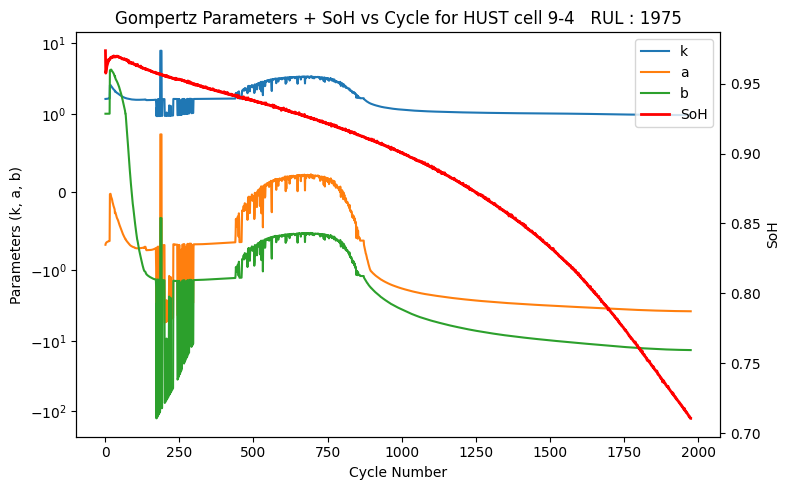

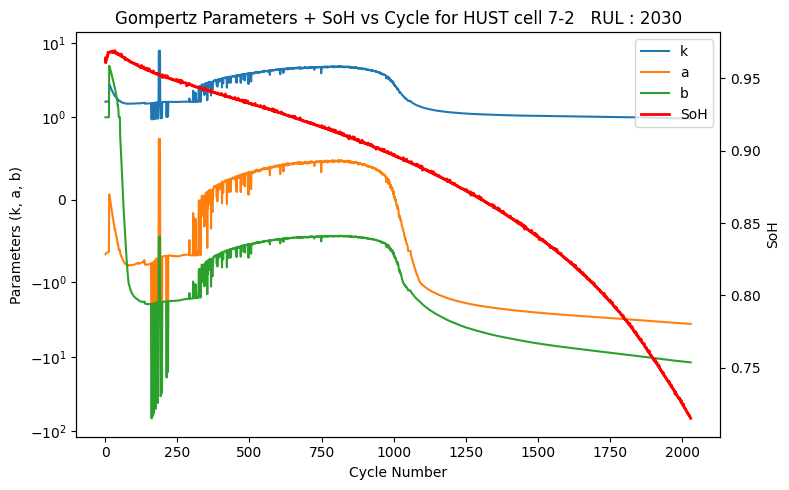

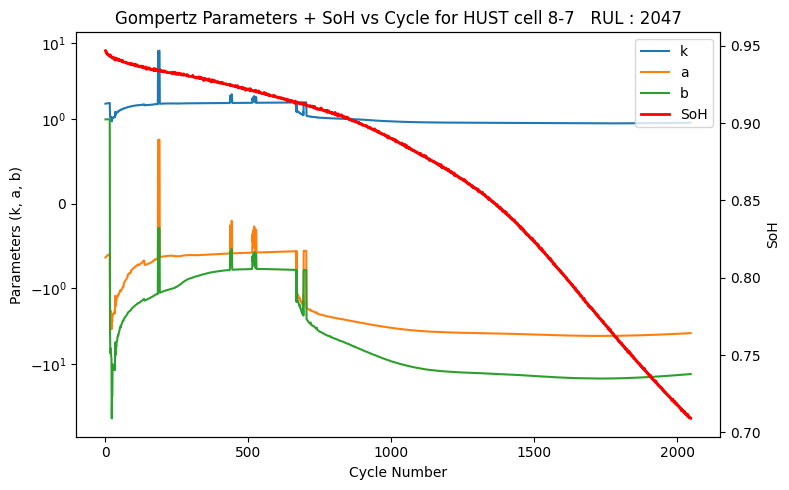

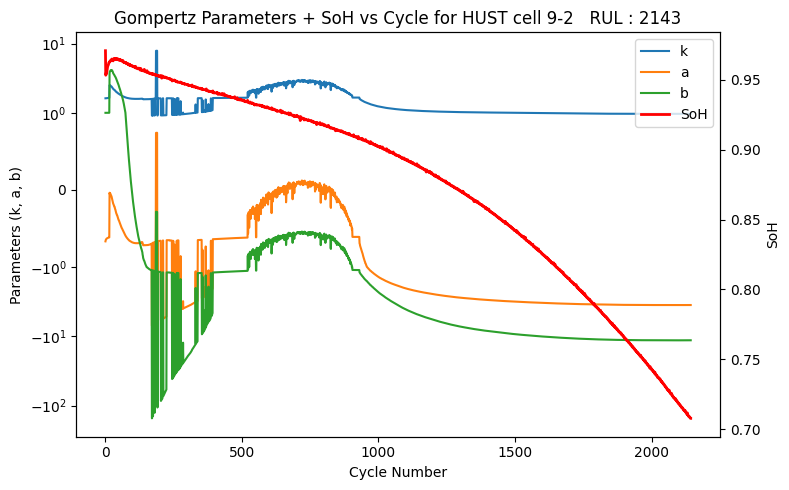

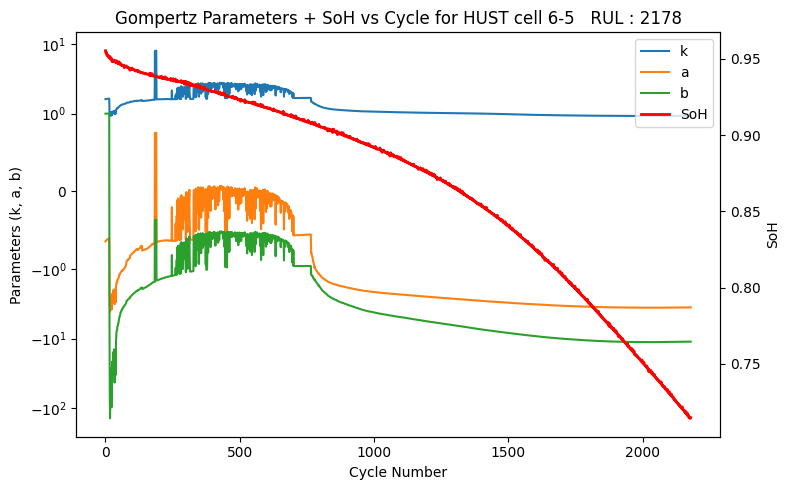

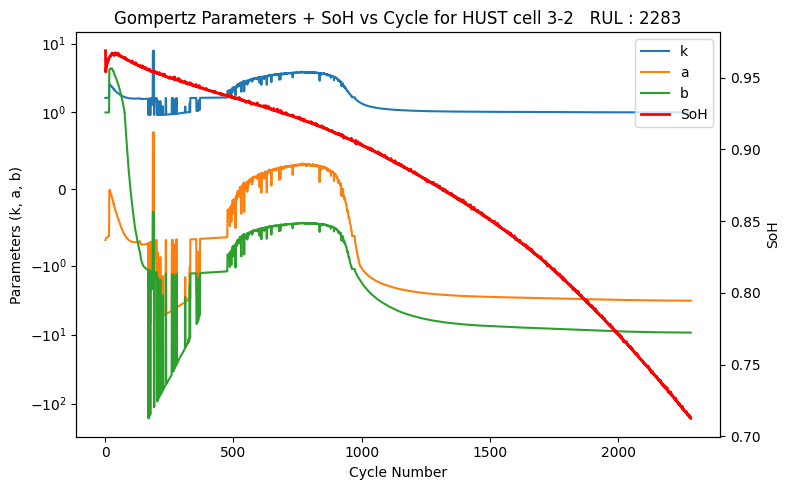

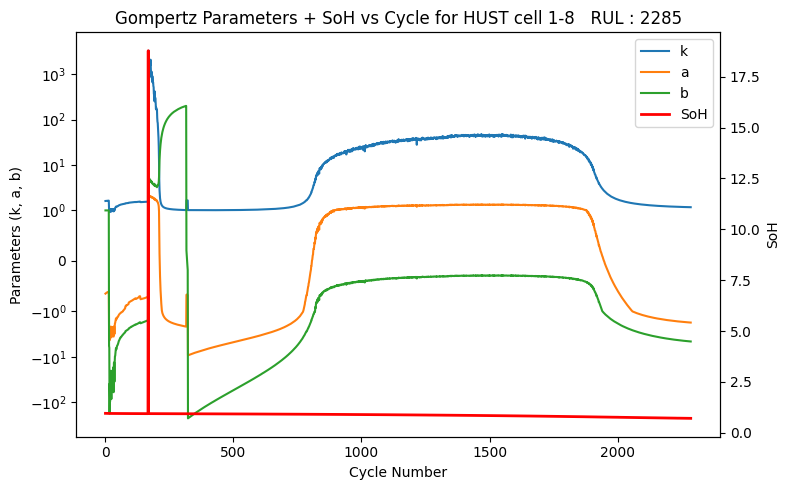

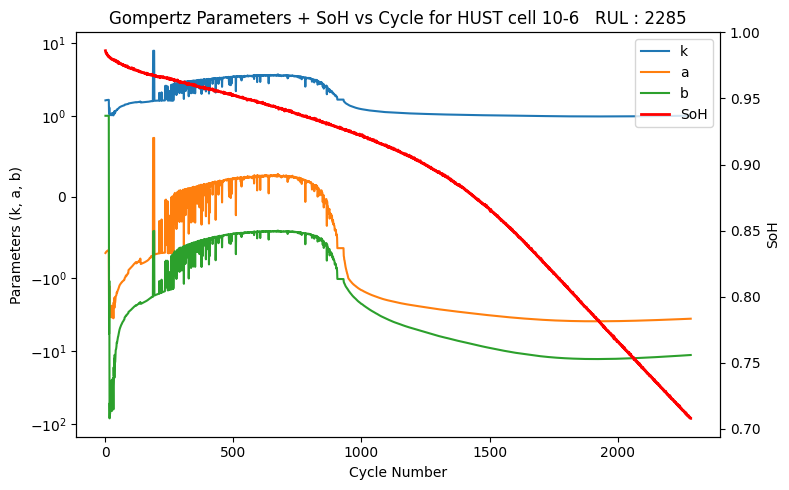

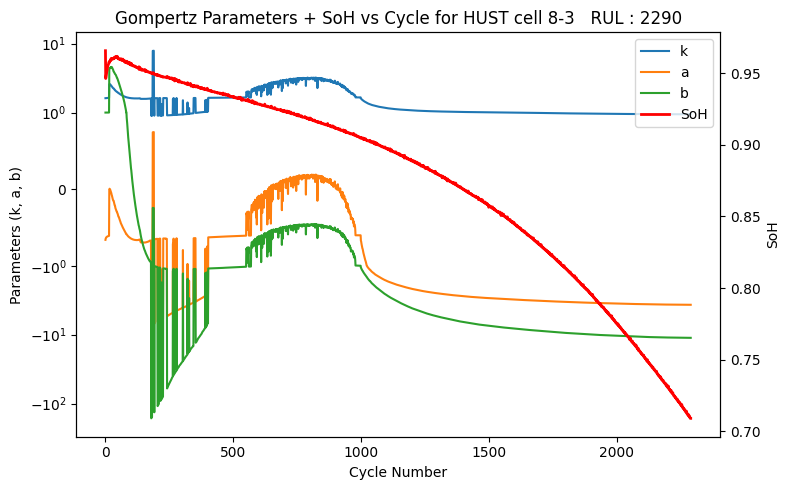

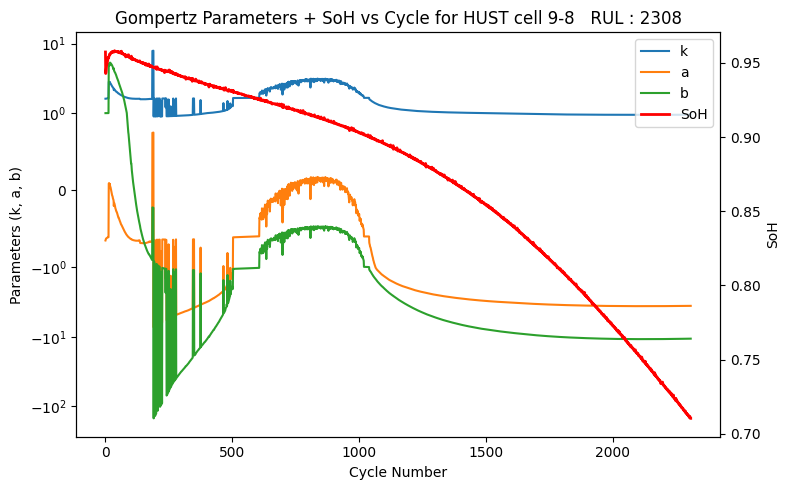

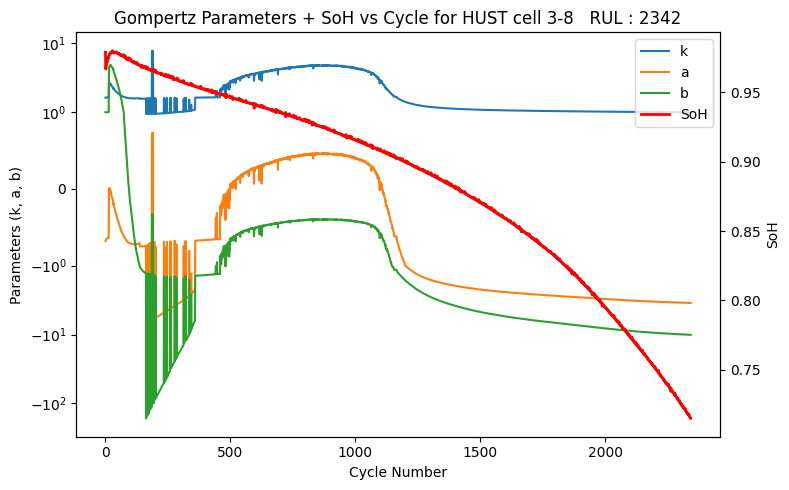

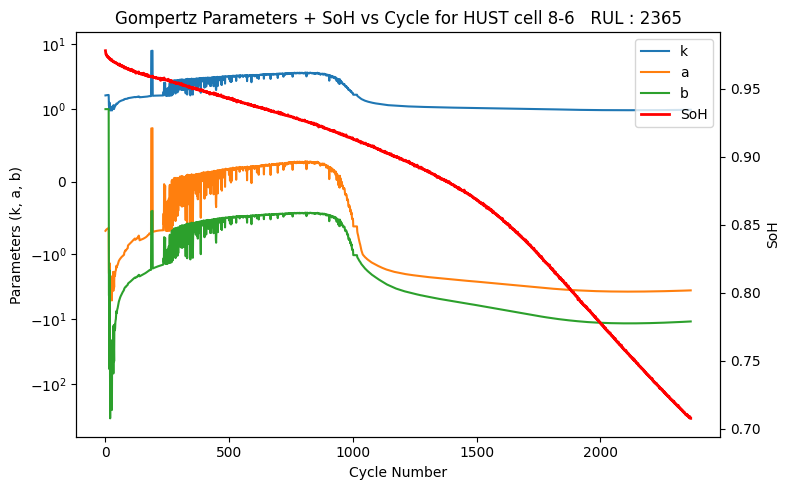

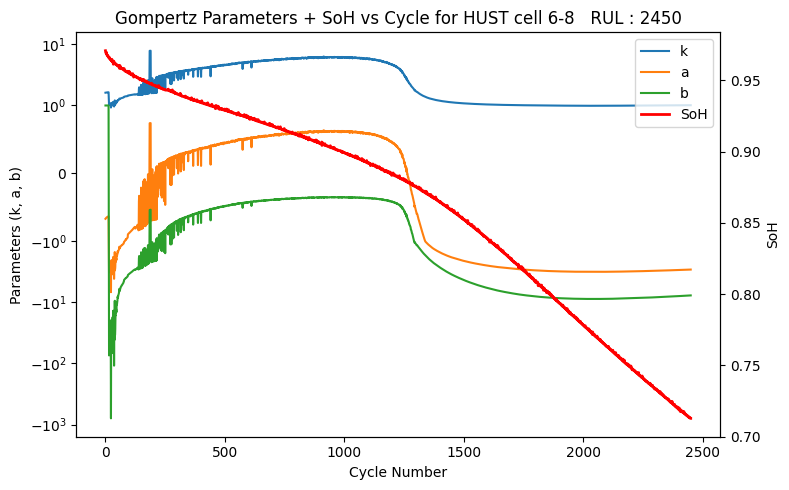

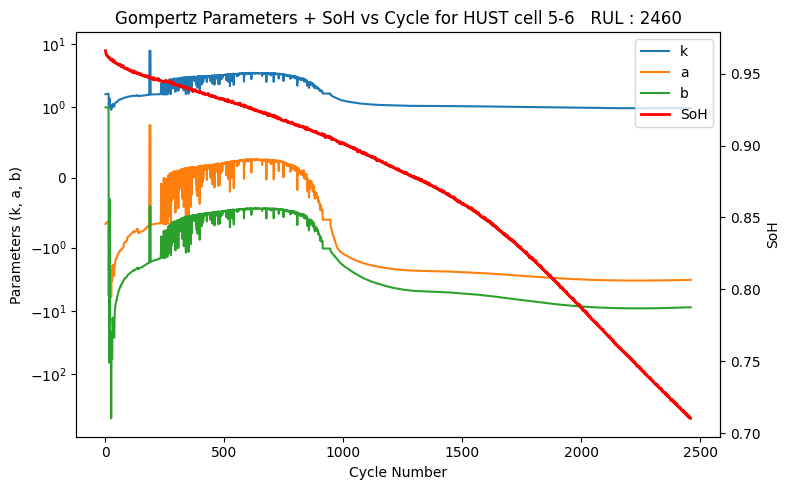

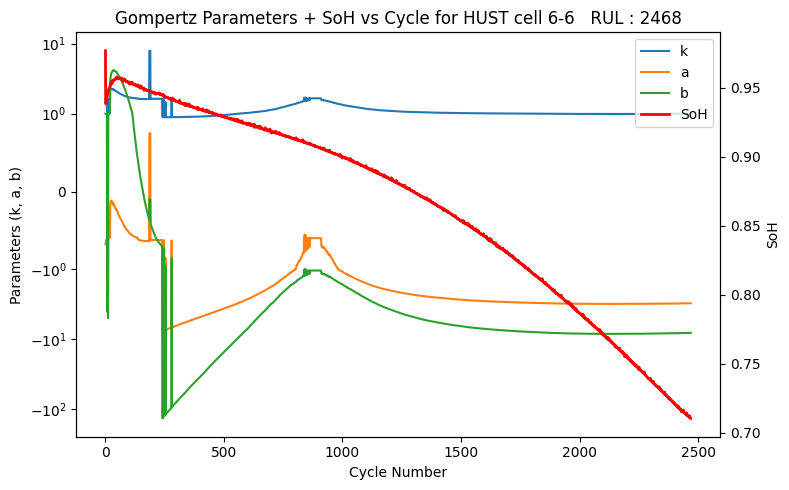

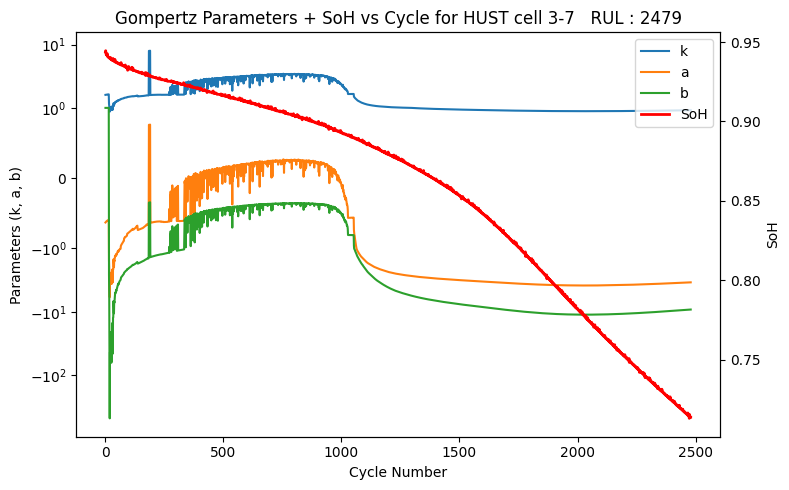

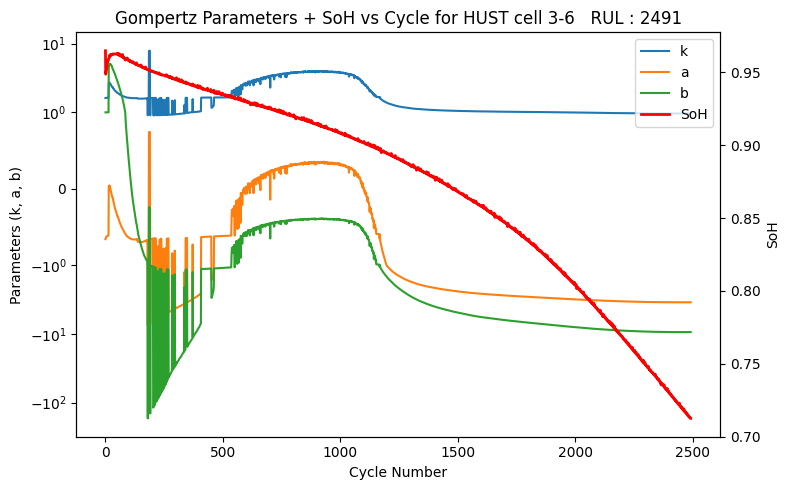

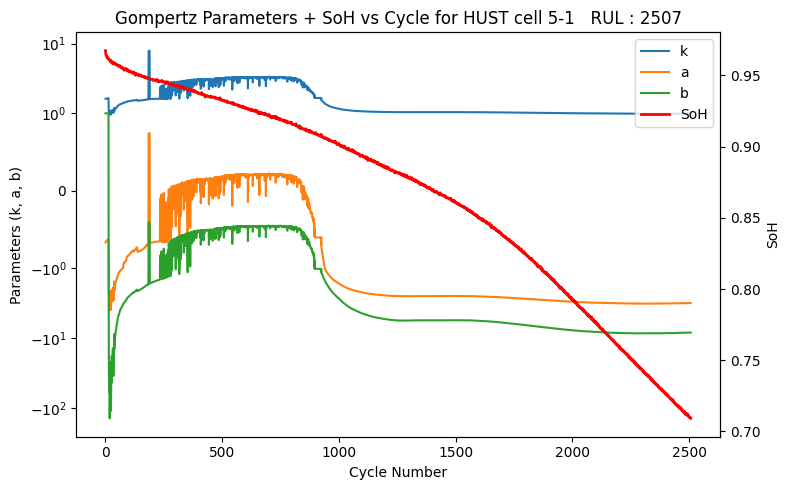

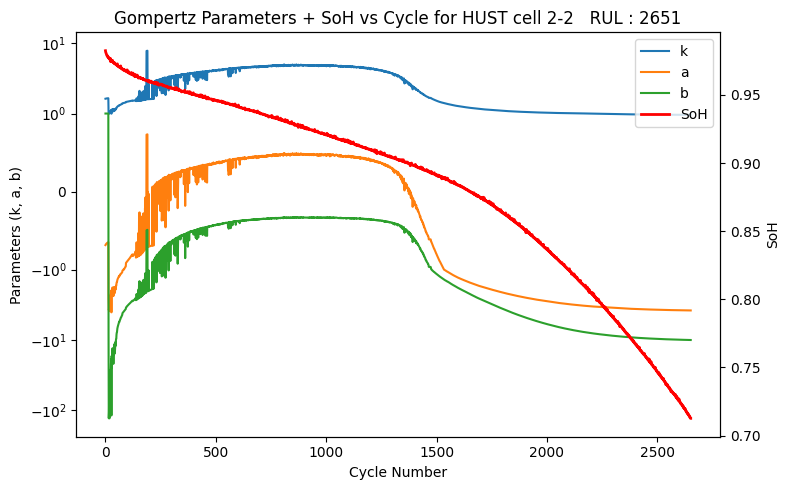

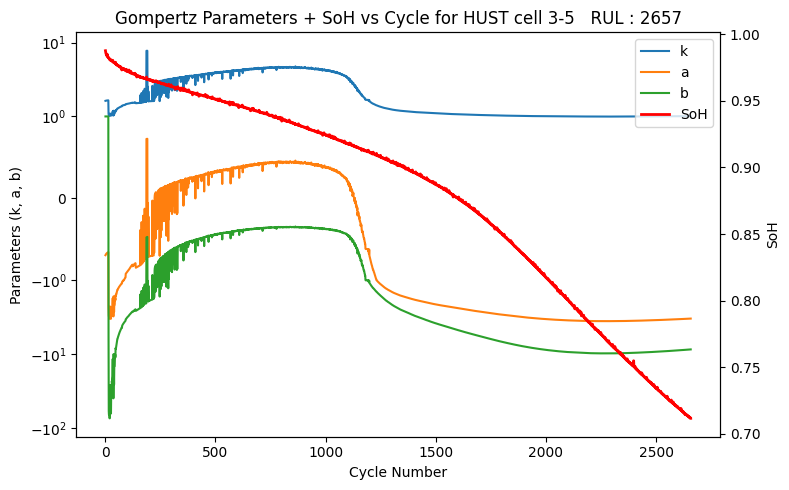

In [15]:
os.makedirs('Parameter-Plots/',exist_ok=True)

for choice in pairs:
    gompertz_df_full = pd.read_csv(base_path + choice + "-hust_gompertz_params.csv")
    
    plt.figure(figsize=(8, 5))

    x = gompertz_df_full["Cycle number"]
    
    # --- Left axis ---
    ax1 = plt.gca()
    for col in ["k", "a", "b"]:
        ax1.plot(x, gompertz_df_full[col], label=col)
    
    ax1.set_xlabel("Cycle Number")
    ax1.set_ylabel("Parameters (k, a, b)")
    ax1.set_yscale('symlog', linthresh=1)
    
    # --- Right axis ---
    ax2 = ax1.twinx()
    ax2.plot(x, gompertz_df_full["SoH"], color="red", label="SoH", linewidth=2)
    ax2.set_ylabel("SoH")
    
    # --- Title ---
    plt.title(f"Gompertz Parameters + SoH vs Cycle for HUST cell {choice}   RUL : {cycle_lengths_sort[choice]}")
    
    # --- Combined legend ---
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper right")
    
    plt.tight_layout()
    plt.savefig(f"Parameter-Plots/HUST-cell-{choice}-Two-Y.png", dpi=300)
    plt.show()

    #break

In [16]:
unified_gompertz = {}
for choice in pairs:
    #get file
    gompertz_df_full = pd.read_csv(base_path + choice + "-hust_gompertz_params.csv")
    #add cell name
    gompertz_df_full['cell_name'] = [choice]*gompertz_df_full.shape[0]
    for i in range(1,max(cycle_lengths)+1,1):
        try:
            temp_data = gompertz_df_full[gompertz_df_full["Cycle number"]==i].iloc[0].to_dict()
        except:
            temp_data = {'Cycle number': i, 'k': None, 'a': None,'b': None, 'rul': None, 'max_SoC_above_80': None,'SoH': None, 'cell_name': choice}
        try:
            unified_gompertz[str(i)].append(temp_data)
        except:
            unified_gompertz[str(i)] = []
            unified_gompertz[str(i)].append(temp_data)

In [17]:
cycle_lengths_sort

{'6-6': 2468,
 '7-8': 1938,
 '5-3': 2689,
 '6-8': 2450,
 '5-5': 1583,
 '2-4': 1499,
 '10-3': 1848,
 '1-4': 1500,
 '6-3': 1804,
 '5-6': 2460,
 '8-3': 2290,
 '3-6': 2491,
 '10-4': 1811,
 '9-6': 1742,
 '3-2': 2283,
 '9-2': 2143,
 '9-7': 2012,
 '6-5': 2178,
 '4-8': 1706,
 '5-7': 1448,
 '1-5': 1971,
 '1-7': 1678,
 '1-8': 2285,
 '8-7': 2047,
 '6-2': 1908,
 '3-3': 1649,
 '6-1': 1609,
 '2-7': 2202,
 '1-2': 2678,
 '10-7': 1783,
 '10-1': 1702,
 '9-1': 2057,
 '8-5': 1348,
 '9-4': 1975,
 '4-4': 1491,
 '3-4': 1766,
 '10-6': 2285,
 '5-2': 1926,
 '7-5': 1875,
 '4-3': 1142,
 '5-4': 1962,
 '3-5': 2657,
 '7-2': 2030,
 '3-7': 2479,
 '1-3': 1858,
 '9-5': 2168,
 '3-1': 1938,
 '4-1': 2217,
 '9-3': 1905,
 '7-1': 1690,
 '8-8': 1679,
 '6-4': 1717,
 '4-2': 1782,
 '5-1': 2507,
 '2-3': 1751,
 '4-5': 1561,
 '4-6': 1380,
 '2-8': 1481,
 '8-1': 1308,
 '10-8': 1400,
 '9-8': 2308,
 '3-8': 2342,
 '7-3': 1295,
 '8-2': 2041,
 '8-6': 2365,
 '7-6': 1419,
 '10-5': 2030,
 '7-7': 1685,
 '7-4': 1393,
 '4-7': 2216,
 '2-6': 1572,

In [18]:
for k in unified_gompertz.keys():
    unified_gompertz[k] = pd.DataFrame(unified_gompertz[k])

In [19]:
unified_gompertz['100'].dtypes

Cycle number                       int64
k                                float64
a                                float64
b                                float64
rul                                int64
max_SoC_above_80                 float64
SoH                              float64
gompertz-value                   float64
gompertz-1st-derivative-value    float64
gompertz-2nd-derivative-value    float64
cell_name                         object
dtype: object

In [20]:
unified_gompertz['100'][['Cycle number','k','a','b','rul','max_SoC_above_80','SoH']].corr()

Cycle number         k         a         b       rul  \
Cycle number               NaN       NaN       NaN       NaN       NaN   
k                          NaN  1.000000  0.963861  0.984219  0.100226   
a                          NaN  0.963861  1.000000  0.978630 -0.064108   
b                          NaN  0.984219  0.978630  1.000000  0.055912   
rul                        NaN  0.100226 -0.064108  0.055912  1.000000   
max_SoC_above_80           NaN  0.616616  0.392605  0.536499  0.485320   
SoH                        NaN  0.486085  0.248208  0.422517  0.620789   

                  max_SoC_above_80       SoH  
Cycle number                   NaN       NaN  
k                         0.616616  0.486085  
a                         0.392605  0.248208  
b                         0.536499  0.422517  
rul                       0.485320  0.620789  
max_SoC_above_80          1.000000  0.951608  
SoH                       0.951608  1.000000

In [21]:
unified_gompertz['1'][['SoH']].max(),unified_gompertz['1'][['SoH']].min()

(SoH    0.987695
 dtype: float64,
 SoH    0.93409
 dtype: float64)

In [22]:
unified_gompertz['2'].head(50)

Cycle number         k         a         b   rul  max_SoC_above_80  \
0              2  1.607710 -0.621961  1.000243  1141         27.649002   
1              2  1.619494 -0.653543  1.000248  1142         30.534354   
2              2  1.604698 -0.613032  1.000242  1294         27.183925   
3              2  1.607858 -0.622400  1.000243  1307         27.679969   
4              2  1.606347 -0.617915  1.000243  1347         27.363420   
5              2  1.607511 -0.621369  1.000243  1379         27.269036   
6              2  1.610508 -0.629631  1.000240  1385         30.336403   
7              2  1.606014 -0.616927  1.000242  1392         27.358027   
8              2  1.612698 -0.635434  1.000245  1399         28.600341   
9              2  1.607886 -0.622485  1.000243  1418         27.587859   
10             2  1.610736 -0.630227  1.000244  1447         27.844573   
11             2  1.610762 -0.630297  1.000244  1480         27.987736   
12             2  1.606735 -0.619066  1.000243  1490         27.289066   
13             2  1.613198 -0.636761  1.000246  1498         28.522215   
14             2  1.613335 -0.637134  1.000240  1499         31.252474   
15             2  1.607143 -0.620276  1.000243  1503         27.515367   
16             2  1.616695 -0.646069  1.000247  1560         29.445540   
17             2  1.616283 -0.644978  1.000243  1571         31.341165   
18             2  1.614841 -0.641138  1.000241  1582         31.421609   
19             2  1.608361 -0.623898  1.000244  1608         27.575067   
20             2  1.614485 -0.640188  1.000244  1648         30.433580   
21             2  1.613087 -0.636466  1.000245  1677         28.631924   
22             2  1.619022 -0.652289  1.000244  1678         31.883964   
23             2  1.608405 -0.624027  1.000243  1684         27.609592   
24             2  1.614325 -0.639757  1.000246  1689         28.333403   
25             2  1.618203 -0.650097  1.000246  1696         31.011000   
26             2  1.610035 -0.628369  1.000244  1701         27.632777   
27             2  1.617714 -0.648796  1.000243  1705         31.924463   
28             2  1.611710 -0.632809  1.000245  1716         27.906455   
29             2  1.620322 -0.655763  1.000247  1741         31.471886   
30             2  1.612784 -0.635670  1.000241  1750         30.795199   
31             2  1.611250 -0.631590  1.000245  1765         27.528013   
32             2  1.614813 -0.641064  1.000243  1781         30.943443   
33             2  1.616247 -0.644882  1.000243  1782         31.370687   
34             2  1.617251 -0.647559  1.000244  1803         31.501133   
35             2  1.615074 -0.641757  1.000243  1810         31.015556   
36             2  1.614391 -0.639935  1.000246  1847         28.340492   
37             2  1.612291 -0.634362  1.000240  1857         30.994334   
38             2  1.615833 -0.643779  1.000243  1874         31.183412   
39             2  1.610976 -0.630864  1.000245  1884         27.963377   
40             2  1.619848 -0.654496  1.000246  1904         31.750058   
41             2  1.619078 -0.652441  1.000244  1907         32.201764   
42             2  1.613639 -0.637941  1.000241  1925         30.979524   
43             2  1.615892 -0.643937  1.000243  1937         31.345985   
44             2  1.617462 -0.648122  1.000244  1937         31.303518   
45             2  1.610123 -0.628603  1.000244  1961         28.143652   
46             2  1.611354 -0.631876  1.000240  1970         30.864264   
47             2  1.620968 -0.657492  1.000246  1974         31.961320   
48             2  1.617829 -0.649100  1.000245  2011         31.298364   
49             2  1.619224 -0.652823  1.000247  2029         30.842698   

         SoH  gompertz-value  gompertz-1st-derivative-value  \
0   0.939403        0.995835                       0.477105   
1   0.961753        1.018232                       0.472623   
2   0.933143        0.997000            

In [ ]:
os.makedirs('Parameter-Function-Plots/',exist_ok=True)
tRULs, tSoHs, tGompertz_y,tGompertz_dy_dx,tGompertz_d2y_dx2 = [],[], [], [], [] #list of lists
cRULs, cSoHs, cGompertz_y,cGompertz_dy_dx, cGompertz_d2y_dx2 = [],[], [], [], [] #combine single list   
for k in cycle_lengths_sort.keys():
    print(k,cycle_lengths_sort[k])
    if k == '1-8':
        continue #skip cell 1-8 as it has errors found my experiments and in reproducible experiments as per batteryml#
    RULs, SoHs, Gompertz_y,Gompertz_dy_dx, Gompertz_d2y_dx2 = [],[], [], [], []
    for i in range(1,cycle_lengths_sort[k]+1,1):

        row = unified_gompertz[str(i)][unified_gompertz[str(i)]['cell_name'] == k].squeeze()
        # print('SoH : ',row['SoH'],'Gompertz value',row['gompertz-value'])
        RULs.append(row['Cycle number']), SoHs.append((row['SoH'])),Gompertz_y.append(row['gompertz-value']),Gompertz_dy_dx.append(row['gompertz-1st-derivative-value']),Gompertz_d2y_dx2.append(row['gompertz-2nd-derivative-value'])
        cRULs.append(row['Cycle number']), cSoHs.append((row['SoH'])),cGompertz_y.append(row['gompertz-value']),cGompertz_dy_dx.append(row['gompertz-1st-derivative-value']),cGompertz_d2y_dx2.append(row['gompertz-2nd-derivative-value'])
    #Reverse SoHs and Gomperz so that plots are in reducing RUL order
    # RULs = RULs[::-1]
    # SoHs = SoHs[::-1]
    # Gompertz_y = Gompertz_y[::-1]
    # Gompertz_dy_dx = Gompertz_dy_dx[::-1]
    tRULs.append(RULs), tSoHs.append(SoHs),tGompertz_y.append(Gompertz_y),tGompertz_dy_dx.append(Gompertz_dy_dx),tGompertz_d2y_dx2.append(Gompertz_d2y_dx2)
    
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    # Plot Gompertz_y and Gompertz_dy_dx on the primary axis (ax1)
    # Storing the line objects to create a combined legend later
    l1, = ax1.plot(SoHs, Gompertz_y, color='red', label='Gompertz (y)')
    l2, = ax1.plot(SoHs, Gompertz_dy_dx, linestyle='-', color='blue', label='Gompertz (dy/dx)')
    
    # Configure the primary axis
    ax1.set_xlabel('SoH')
    ax1.set_ylabel('Gompertz (y) & (dy/dx)') # Label for left axis
    #ax1.set_yscale('log')
    ax1.grid(True, linestyle='--', alpha=0.7)
    
    # Create the secondary axis (right side) sharing the same x-axis
    ax2 = ax1.twinx()
    
    # Plot Gompertz_d2y_dx2 on the secondary axis (ax2)
    l3, = ax2.plot(SoHs, Gompertz_d2y_dx2, color='orange', label='Gompertz (d2y/dx2)')
    
    # Configure the secondary axis
    ax2.set_ylabel('Gompertz (d2y/dx2)', color='orange') # Label for right axis
    ax2.tick_params(axis='y', labelcolor='orange')       # Color the ticks to match
    #ax2.set_yscale('log')
    
    # Combine legends from both axes
    lines = [l1, l2, l3]
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='best') 
    
    # Title and Save
    plt.title(f'Relationship between SoH and Gompertz (y), (dy/dx) & (d2y/dx2) Cell : {k}')
    plt.savefig(f'Parameter-Function-Plots/cell-name-{k}-Cycle-y-dy-dx-d2y-dx2-1.png')
    plt.show()



    
    # Create the figure and the primary axis (left side)
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    # Plot Gompertz_y and Gompertz_dy_dx on the primary axis (ax1)
    # Storing the line objects to create a combined legend later
    l1, = ax1.plot(RULs, Gompertz_y, color='red', label='Gompertz (y)')
    l2, = ax1.plot(RULs, Gompertz_dy_dx, linestyle='-', color='blue', label='Gompertz (dy/dx)')
    
    # Configure the primary axis
    ax1.set_xlabel('RUL (cycles)')
    ax1.set_ylabel('Gompertz (y) & (dy/dx)') # Label for left axis
    #ax1.set_yscale('log')
    ax1.grid(True, linestyle='--', alpha=0.7)
    
    # Create the secondary axis (right side) sharing the same x-axis
    ax2 = ax1.twinx()
    
    # Plot Gompertz_d2y_dx2 on the secondary axis (ax2)
    l3, = ax2.plot(RULs, Gompertz_d2y_dx2, color='orange', label='Gompertz (d2y/dx2)')
    
    # Configure the secondary axis
    ax2.set_ylabel('Gompertz (d2y/dx2)', color='orange') # Label for right axis
    ax2.tick_params(axis='y', labelcolor='orange')       # Color the ticks to match
    #ax2.set_yscale('log')
    
    # Combine legends from both axes
    lines = [l1, l2, l3]
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='best') 
    
    # Title and Save
    plt.title(f'Relationship between RUL and Gompertz (y), (dy/dx) & (d2y/dx2) Cell : {k}')
    plt.savefig(f'Parameter-Function-Plots/cell-name-{k}-Cycle-y-dy-dx-d2y-dx2-2.png')
    plt.show()
        #break
    #break

In [ ]:
# Create the figure and the primary axis (left side)
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Gompertz_y and Gompertz_dy_dx on the primary axis (ax1)
# Storing the line objects to create a combined legend later
l1, = ax1.plot(cSoHs, cGompertz_y, color='red', label='Gompertz (y)')
l2, = ax1.plot(cSoHs, cGompertz_dy_dx, linestyle='-', color='blue', label='Gompertz (dy/dx)')

# Configure the primary axis
ax1.set_xlabel('SoH')
ax1.set_ylabel('Gompertz (y) & (dy/dx)') # Label for left axis
#ax1.set_yscale('log')
ax1.grid(True, linestyle='--', alpha=0.7)

# Create the secondary axis (right side) sharing the same x-axis
ax2 = ax1.twinx()

# Plot Gompertz_d2y_dx2 on the secondary axis (ax2)
l3, = ax2.plot(cSoHs, cGompertz_d2y_dx2, color='orange', label='Gompertz (d2y/dx2)')

# Configure the secondary axis
ax2.set_ylabel('Gompertz (d2y/dx2)', color='orange') # Label for right axis
ax2.tick_params(axis='y', labelcolor='orange')       # Color the ticks to match
#ax2.set_yscale('log')

# Combine legends from both axes
lines = [l1, l2, l3]
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='best') 

# Title and Save
plt.title(f'Relationship between SoH and Gompertz (y), (dy/dx) & (d2y/dx2) for all cells')
plt.savefig(f'combined-SoH-y-dy-dx.png')
plt.show()

In [ ]:
cell_mins, cell_maxs = [], []
for cell in tSoHs:
    cell_min = (min(cell))
    cell_max = (max(cell))
    cell_mins.append(cell_min)
    cell_maxs.append(cell_max)
    #print(cell_min)
print('Local lowest cut off : ',min(cell_mins),' \nGlobal lowest cut off ',max(cell_mins))
print('Local highest cut off : ',min(cell_maxs),' \nGlobal highest cut off ',max(cell_maxs))

In [25]:
corr = unified_gompertz['1000'][['Cycle number','k','a','b','rul','max_SoC_above_80','SoH']].corr()#df.corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

In [26]:
temp_data = gompertz_df_full[gompertz_df_full["Cycle number"]==1].iloc[0].to_dict()
temp_data

{'Cycle number': 1,
 'k': 1.617734965592151,
 'a': -0.6621505468495669,
 'b': 1.0001662186797131,
 'rul': 2689,
 'max_SoC_above_80': 30.101007853534725,
 'SoH': 0.965929123847164,
 'gompertz-value': 1.0907932532009808,
 'gompertz-1st-derivative-value': 0.4299768747466153,
 'gompertz-2nd-derivative-value': -0.2605569108119149,
 'cell_name': '5-3'}

In [32]:
values = sorted(cycle_lengths)
import numpy as np
bins = np.linspace(min(values), max(values), 4)
digitized = np.digitize(values, bins)

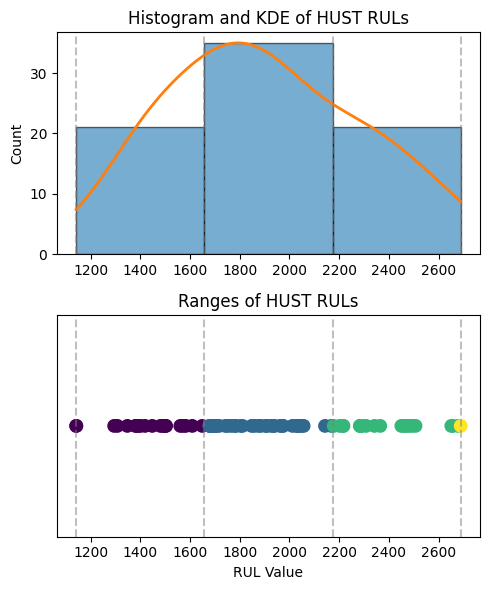

In [33]:
from scipy.stats import gaussian_kde


k = 3

# KDE estimator
kde = gaussian_kde(values)

# Smooth x-grid for KDE
x_grid = np.linspace(min(values), max(values), 500)
kde_vals = kde(x_grid)

# Compute histogram counts WITHOUT density=True
hist_counts, hist_bins = np.histogram(values, bins=bins)

# Scale KDE to match histogram peak
kde_scaled = kde_vals * max(hist_counts) / max(kde_vals)

# --- Plot ---
fig, axes = plt.subplots(2, 1, figsize=(5, 6), sharex=False)

# 1️⃣ Histogram (counts) + scaled KDE
axes[0].hist(values, bins=bins, edgecolor="black", alpha=0.6)   # counts mode

# Plot scaled KDE
axes[0].plot(x_grid, kde_scaled, linewidth=2)

axes[0].set_title("Histogram and KDE of HUST RULs")
axes[0].set_ylabel("Count")

# Bin edges
for b in bins:
    axes[0].axvline(b, color='gray', linestyle='--', alpha=0.5)

# 2️⃣ Scatter plot with bin edges
axes[1].scatter(values, np.zeros_like(values), c=digitized, s=80)
for b in bins:
    axes[1].axvline(b, color='gray', linestyle='--', alpha=0.5)

axes[1].set_yticks([])
axes[1].set_title("Ranges of HUST RULs")
axes[1].set_xlabel("RUL Value")

plt.tight_layout()
plt.show()

In [34]:
print(bins)

[1142.         1657.66666667 2173.33333333 2689.        ]


In [43]:
print(hist_counts) #how many cells per bin?

[21 35 21]


In [44]:
def plot_battery_fade(x, y, choice):
    """
    Plots battery capacity fade with intersection points labeled next to the markers.
    
    Args:
        x (array-like): Cycle numbers.
        y (array-like): State of Health (SoH) or Capacity values.
        choice (str/int): Identifier for the battery (e.g., cell ID).
    """
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.plot(x, y, label=f"Bat {choice}", color='b') # Uncomment if you want the main line
    
    ax.set_xlabel('Cycle number')
    ax.set_ylabel('SoH')
    ax.set_title(f'HUST Battery {choice} Capacity Fade')
    
    # --- FIX START: Force plot to start at 0,0 ---
    ax.set_xlim(left=0)   # X-axis starts at 0
    ax.set_ylim(bottom=70) # Y-axis starts at 0
    # ---------------------------------------------
    
    x_hits = []
    y_hits = []
    
    # Horizontal reference lines
    for val in range(72, 93+3+1, 3):
        # ax.axhline(y=val, color='r', linestyle='--', linewidth=0.8)
        
        # Find intersection
        # Check if 'y' exists before this; assuming it's defined elsewhere
        idx = np.where(np.diff(np.sign(y - val)))[0]
        if len(idx) > 0:
            i = idx[0]
            x_int = x[i] + (x[i+1] - x[i]) * (val - y[i]) / (y[i+1] - y[i])
            
            # Save intersection
            x_hits.append(x_int)
            y_hits.append(val)
            
    #         # Draw vertical line and label
    #         # ax.axvline(x=x_int, color='k', linestyle='-', linewidth=0.8)
    #         ax.text(x_int, 107, f"{int(x_int)}", rotation=45,
    #                 va='bottom', ha='center', fontsize=7, color='k')
    
    # # --- Plot intersection points ---
    # ax.scatter(x_hits, y_hits, color='k', s=20, zorder=5, label='Intersections')
    # --- PLOT TEXT NEARBY ---
            # Instead of 107, we use 'val + 0.5' to place it just above the point
            ax.text(x_int, val + 0.4, f"{int(x_int)}", 
                    rotation=0,         # No rotation needed if close to point
                    va='center',        # Anchor bottom of text to the point
                    ha='left',        # Center horizontally
                    fontsize=8, 
                    color='black',
                    fontweight='bold')
    
    # --- Plot all intersection points at once ---
    if x_hits:
        ax.scatter(x_hits, y_hits, color='k', s=20, zorder=5, label='Intersections')
    
    plt.legend()
    plt.tight_layout()
    plt.show()

In [45]:
# Define the function
def gompertz_func(x,k,a,b):
    return k*np.exp(-np.exp(a-(b*x)))

def inverse_gompertz_func(y,k,a,b):
    return (a - np.log(np.log(k/y)))/b

def plot_inverse_mapping_strategy(df,df_target,current_soh,k,a,b,SoH_threshold=None,choice=None,cycle_nums=[]):
    x = np.array([j/10000 for j in range(1,3000,1)]) #df['Cycle number'].to_numpy()/10000
    # Compute y values
    y = gompertz_func(x,k,a,b)
    print("70% SoH RUL estimation: ",int(inverse_gompertz_func(y=0.7,k=k,a=a,b=b)*10000))
    # Plot the function
    plt.figure(figsize=(8, 5))
    
    # plt.plot(df['Cycle number']/len(df['Cycle number']), ((df['max_SOC']-80)/(df['max_SOC'].max()-80)), label="Bat 2-2")
    # plt.plot(x[:len(df['SoH'])], ((df['SoH']-80)/(115-80)), label=choice,color='b')
    plt.plot(x[:len(df['SoH'])], df['SoH'], label=f'{choice} - available SoH curve',color='b',linestyle='-', linewidth=2)
    plt.plot(x[:len(df_target['SoH'])], df_target['SoH'], label=f'{choice} - target SoH curve',color='green',linestyle='dotted', linewidth=2)
    plt.plot(x, y, label=r'Gompertz function', color='r',linestyle='-', linewidth=1)
    # plt.axhline(0, color='black', linewidth=0.5)
    # plt.axhline(1, color='black', linewidth=0.5)
    # plt.axvline(0, color='black', linewidth=0.5)
    plt.xlabel("normalized Cycle Number (x)")
    plt.ylim(0.6, 1)
    plt.xlim(0, 0.3)
    plt.ylabel("SoH")
    plt.title(f"Prediction at {current_soh} SoH", fontsize=12, fontweight='bold')
    #f"Plot of gompertz function k = {round(k,2)}, a = {round(a,2)} and b = {round(b,2)}")
    plt.grid(not True)
    plt.axhline(y=0.7, color='black', label=f'Failure Threshold (0.7 SoH)')
    plt.axvline(x=len(df['SoH'])/10000, color='grey', label='Current Cycle')
    if current_soh == '93%':
        plt.legend()
    # Show the plot
    plt.show()

# FIX CELL BELOW

In [37]:
def obtain_SoH_thresholds_and_cycle_nums(df):
    '''
    Given a dataframe with SoH values as well as Cycle numbers, this function should return
    the cycles needed to reach following SoH thresholds 'BoL','96%','93%','90%','87%','84%','81%','78%','75%','72%','EoL'/'70%'
    '''

    df['SoH'] = ((df['SoH'])*100)

    BoL_SoH, EoL_SoH = 1, len(df['SoH'])
    
    # x = df['Cycle number'].to_numpy()
    # y = df['SoH'].to_numpy()
    
    # # Horizontal reference lines
    # for val in range(72, 93+3+1, 3):
    #     # --- Find intersection ---
    #     # Compute where SoH crosses the horizontal line
    #     idx = np.where(np.diff(np.sign(y - val)))[0]
    #     if len(idx) > 0:
    #         # Take first intersection (or loop for all)
    #         i = idx[0]
    #         # Linear interpolation between points
    #         x_int = x[i] + (x[i+1] - x[i]) * (val - y[i]) / (y[i+1] - y[i])
            
    #         # Draw vertical line
    #         #ax.axvline(x=x_int, color='k', linestyle='-', linewidth=0.4)
    #         # Add label
    #         #ax.text(x_int, 79, f"{int(x_int)}", rotation=90,
    #         #        va='bottom', ha='center', fontsize=7, color='k')
    
    x = df['Cycle number'].to_numpy()
    y = df['SoH'].to_numpy()
    
    
    x_hits = []
    y_hits = []
    
    # Horizontal reference lines
    for val in range(72, 93+3+1, 3):
        
        # Find intersection
        idx = np.where(np.diff(np.sign(y - val)))[0]
        if len(idx) > 0:
            i = idx[0]
            x_int = x[i] + (x[i+1] - x[i]) * (val - y[i]) / (y[i+1] - y[i])
            
            # Save intersection
            x_hits.append(x_int)
            y_hits.append(val)
    x_values = [int(k) for k in x_hits][::-1]
    df['SoH'] = ((df['SoH'])/100)
    return [BoL_SoH,*x_values,EoL_SoH] #unpack all values

In [38]:
def plot_SoH_curves(df):
    # Create figure with subplots
    fig = plt.figure()
    
    plt.plot(df['Cycle number'], ((df['SoH'])), label=f"Bat {choice}")
    
    plt.xlabel('Cycle number')
    plt.ylabel('SoH')
    plt.title(f'HUST Battery {choice} Capacity Fade')
    
    plt.tight_layout()
    plt.show()

[1, 1, 554, 1019, 1320, 1543, 1722, 1872, 2008, 2133, 2168]
9-5


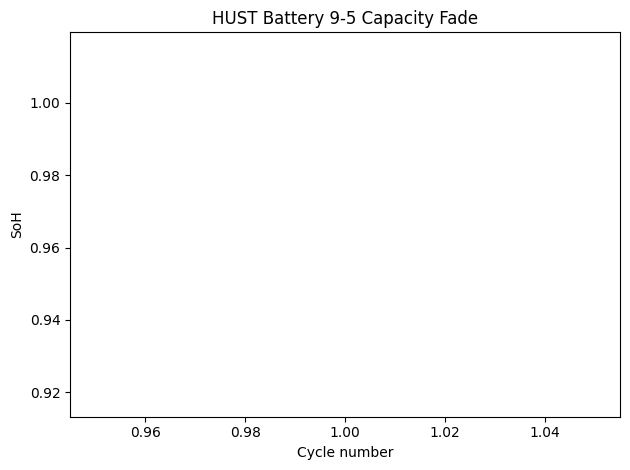

SoH Threshold :  BoL
1.6179584452531688 -0.6628048796689333 1.000166275919657
70% SoH RUL estimation:  -4857


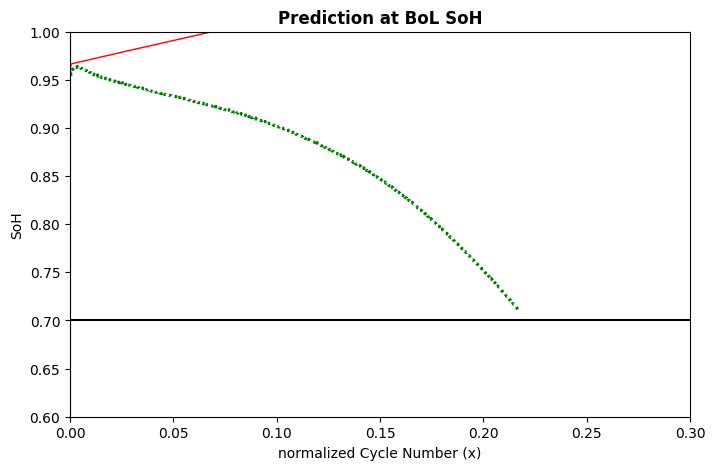

9-5


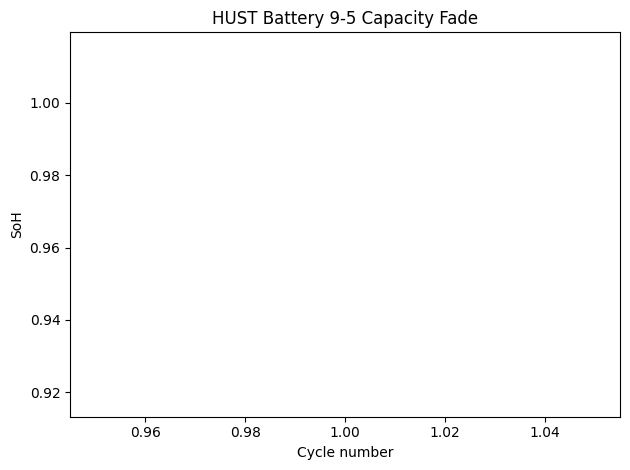

SoH Threshold :  96%
1.6179584452531688 -0.6628048796689333 1.000166275919657
70% SoH RUL estimation:  -4857


9-5


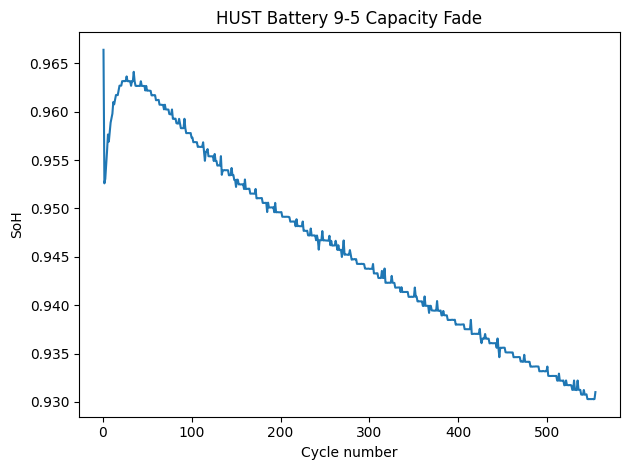

SoH Threshold :  93%
3.049704605336914 0.1424248321459204 -0.5493364588380886
70% SoH RUL estimation:  4441


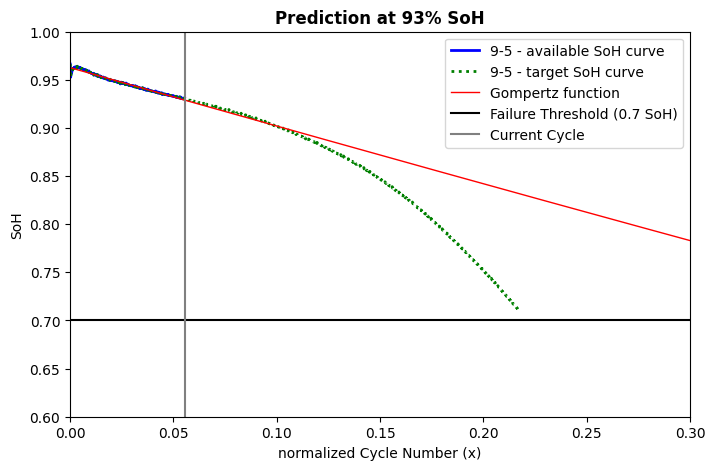

9-5


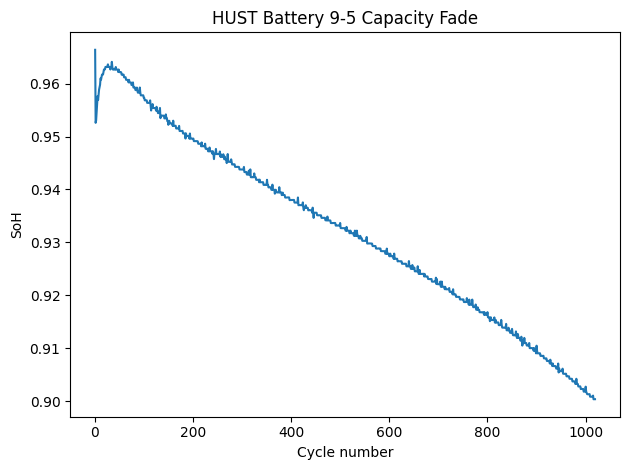

SoH Threshold :  90%
1.79602945538212 -0.4714295842810858 -0.9630811512707136
70% SoH RUL estimation:  4277


9-5


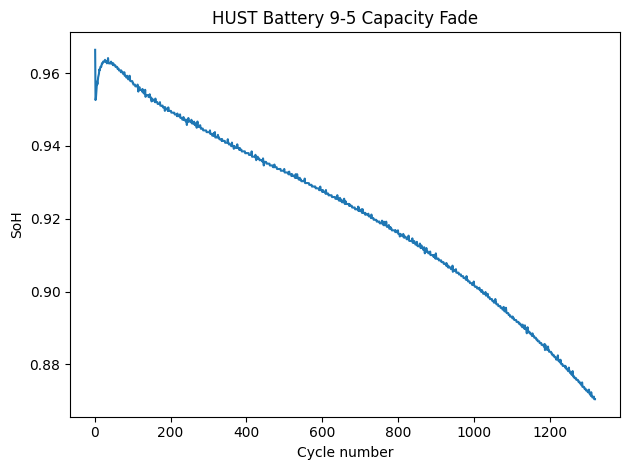

SoH Threshold :  87%
1.034805617146515 -2.590264450400018 -6.184479955983219
70% SoH RUL estimation:  2669


9-5


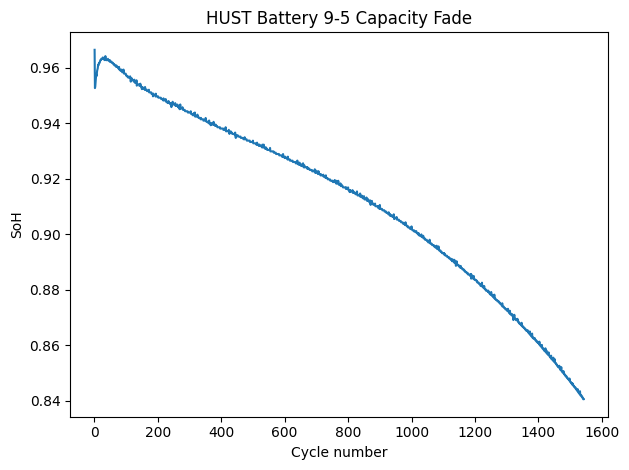

SoH Threshold :  84%
1.0031048221277818 -3.0888888301641098 -8.645898114633875
70% SoH RUL estimation:  2390


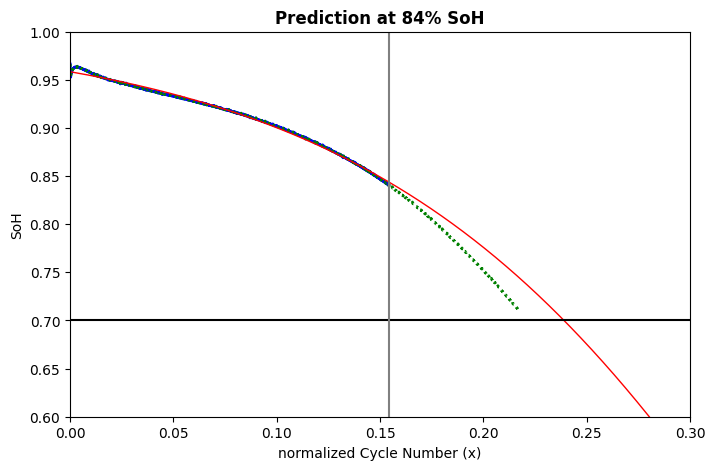

9-5


SoH Threshold :  81%
0.991406921783812 -3.349631310161959 -10.0371243775968
70% SoH RUL estimation:  2285


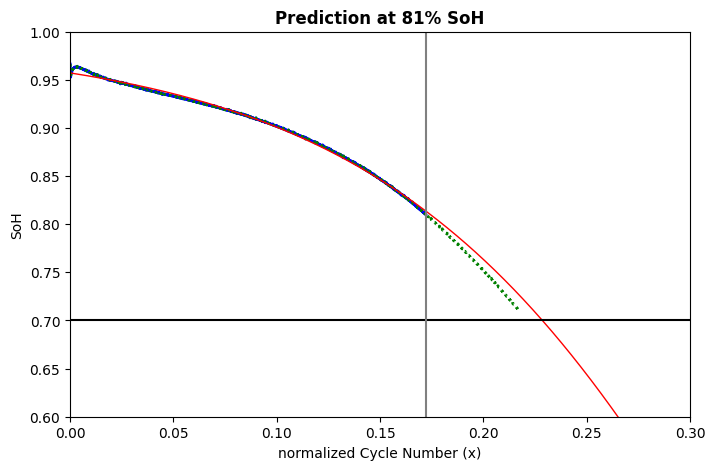

9-5


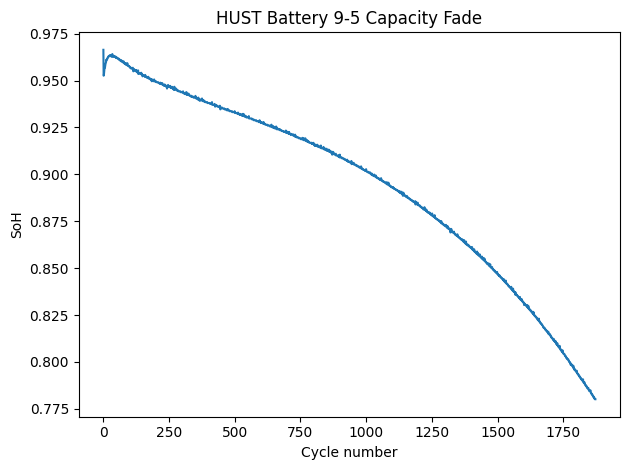

SoH Threshold :  78%
0.9853555010556468 -3.5082182631286725 -10.883805950283405
70% SoH RUL estimation:  2237


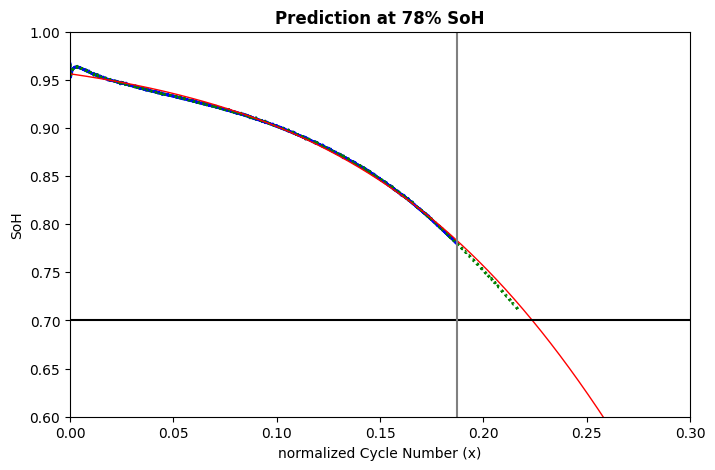

9-5


SoH Threshold :  75%
0.9825087836962942 -3.5885342920059067 -11.303223539696225
70% SoH RUL estimation:  2217


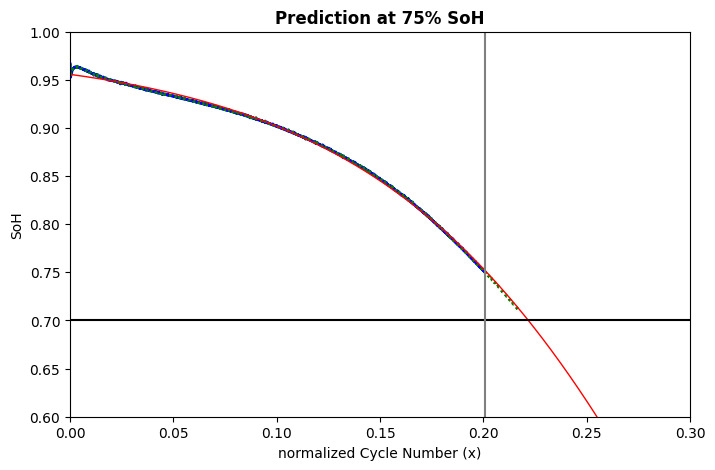

9-5


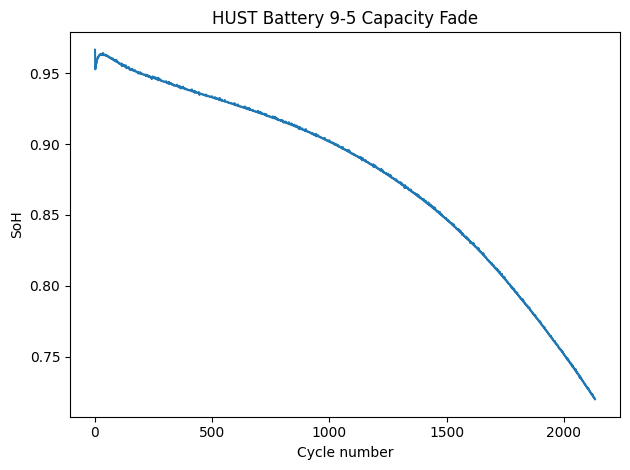

SoH Threshold :  72%
0.9815498201883258 -3.6160295930240287 -11.442358494135256
70% SoH RUL estimation:  2212


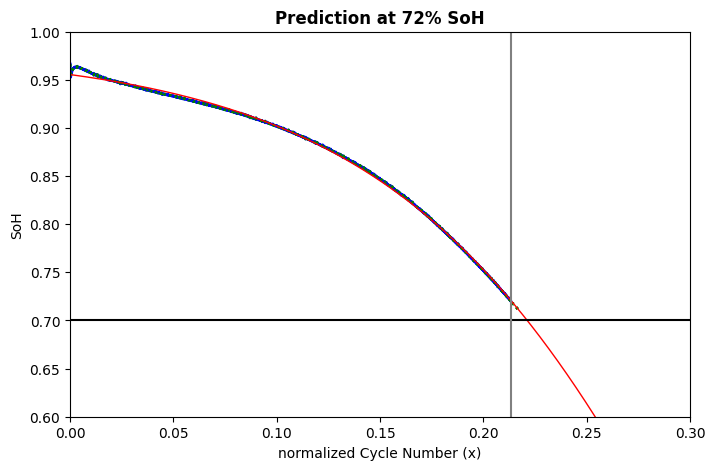

9-5


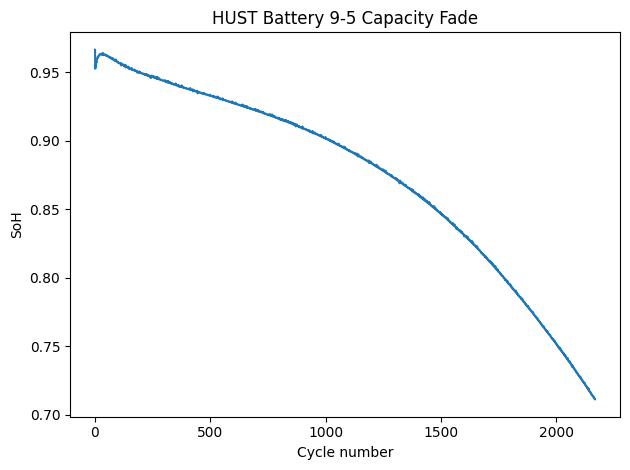

SoH Threshold :  70%
0.981464048104044 -3.618466782745229 -11.45437692459502
70% SoH RUL estimation:  2211


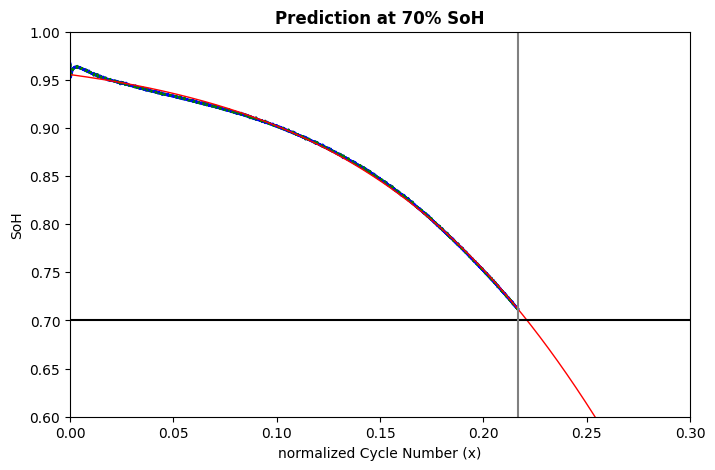

In [41]:
choice = random.choice(pairs)
df = pd.read_csv(base_path + choice + "-hust_gompertz_params.csv")
df['SoH'] = ((df['SoH']))
SoH_Thresholds = ['BoL','96%','93%','90%','87%','84%','81%','78%','75%','72%','70%']
cycle_nums = obtain_SoH_thresholds_and_cycle_nums(df)
print(cycle_nums)
#[1,511,941,1193,1380,1532,1663,1778,1886,1938] #[63,431,637,758,849,925, 992, 1054,1110,1142] #[548,1031,1423,1756,1972,2153,2315,2473,2628,2688]
for i, cycle_num in enumerate(cycle_nums):
    print(choice)
    temp_df = df[df['Cycle number']<=cycle_num]
    plot_SoH_curves(temp_df)
    print('SoH Threshold : ',SoH_Thresholds[i])
    temp_df = df[df['Cycle number']==cycle_num]
    k,a,b = temp_df['k'].item(),temp_df['a'].item(),temp_df['b'].item()
    print(k,a,b)
    #temp_df.head()
    # gompertz_func(x=df,k=k,a=a,b=b)
    plot_inverse_mapping_strategy(df=df.iloc[0:cycle_num],df_target=df,current_soh=SoH_Thresholds[i],k = k,a = a,b = b,choice=choice)

    

In [ ]:
# # ... (your existing data loading)

# plt.figure(figsize=(6, 4))

# # 1. Plot Data
# plt.plot(x_train, y_train, 'b-', label='Available Data', linewidth=2)
# plt.plot(x_test, y_test, 'g:', label='Ground Truth', linewidth=2, alpha=0.7)
# plt.plot(x_full, y_pred, 'r-', label='Gompertz Prediction', linewidth=1.5)

# # 2. Add "Present Time" Marker
# cutoff_cycle = x_train[-1]
# plt.axvline(x=cutoff_cycle, color='gray', linestyle='--', alpha=0.5)
# plt.text(cutoff_cycle, 0.72, ' Forecast Start', verticalalignment='bottom', fontsize=9, color='gray')

# # 3. Add Failure Threshold
# plt.axhline(y=0.7, color='black', linestyle='-', linewidth=1.5, label='Failure Threshold')

# # 4. Clean Titles & Labels
# plt.title(f"Prediction at {current_soh}% SoH", fontsize=12, fontweight='bold')
# plt.xlabel("Cycle Number", fontsize=10) # Use integers if possible!
# plt.ylabel("State of Health (SoH)", fontsize=10)
# plt.grid(False)

# # Only show legend if this is the first plot, otherwise hide it
# # plt.legend() 

# plt.tight_layout()
# plt.show()

# 5. Plot trajectories

In [ ]:
for choice in pairs:
    print('-'*80)
    print(choice)
    df = pd.read_csv(base_path + choice + "-hust_gompertz_params.csv")
    df['SoH'] = ((df['SoH'])*100)
    
    # Create figure
    fig = plt.figure()
    print(len(df['SoH']))
    plt.plot(df['Cycle number'], ((df['SoH']) /1),
             label=f"Bat {choice}", color='b')
    
    plt.xlabel('Cycle number')
    plt.ylabel('SoH %')
    plt.title(f'HUST Battery {choice} Capacity Fade')
    
    # Add horizontal dotted lines
    for val in range(72, 93+3+1, 3):
        #val = round((val-80)/(115-80),4)
        plt.axhline(y=val, color='r', linestyle='--', linewidth=0.8)
        plt.text(df['Cycle number'].max(), val, str(val), va='center', fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    x = df['Cycle number'].to_numpy()
    y = df['SoH'].to_numpy()
    
    # Create figure
    fig, ax = plt.subplots(figsize=(8, 5))
    
    ax.plot(x, y, label=f"Bat {choice}", color='b')
    ax.set_xlabel('Cycle number')
    ax.set_ylabel('SoH')
    ax.set_title(f'HUST Battery {choice} Capacity Fade')
    
    # Horizontal reference lines
    for val in range(72, 93+3+1, 3):
        ax.axhline(y=val, color='r', linestyle='--', linewidth=0.8)
        
        # --- Find intersection ---
        # Compute where SoH crosses the horizontal line
        idx = np.where(np.diff(np.sign(y - val)))[0]
        if len(idx) > 0:
            # Take first intersection (or loop for all)
            i = idx[0]
            # Linear interpolation between points
            x_int = x[i] + (x[i+1] - x[i]) * (val - y[i]) / (y[i+1] - y[i])
            
            # Draw vertical line
            ax.axvline(x=x_int, color='k', linestyle='-', linewidth=0.4)
            # Add label
            ax.text(x_int, 79, f"{int(x_int)}", rotation=90,
                    va='bottom', ha='center', fontsize=7, color='k')
    
    plt.tight_layout()
    plt.show()
    
    x = df['Cycle number'].to_numpy()
    y = df['SoH'].to_numpy()
    plot_battery_fade(x, y, choice)
    # Create figure
    fig, ax = plt.subplots(figsize=(8, 5))
    #ax.plot(x, y, label=f"Bat {choice_csv}", color='b')
    
    ax.set_xlabel('Cycle number')
    ax.set_ylabel('SoH')
    ax.set_title(f'HUST Battery {choice} Capacity Fade')
    
    x_hits = []
    y_hits = []
    
    # Horizontal reference lines
    for val in range(72, 93+3+1, 3):
        #ax.axhline(y=val, color='r', linestyle='--', linewidth=0.8)
        
        # Find intersection
        idx = np.where(np.diff(np.sign(y - val)))[0]
        if len(idx) > 0:
            i = idx[0]
            x_int = x[i] + (x[i+1] - x[i]) * (val - y[i]) / (y[i+1] - y[i])
            
            # Save intersection
            x_hits.append(x_int)
            y_hits.append(val)
            
            # # Draw vertical line and label
            # #ax.axvline(x=x_int, color='k', linestyle='-', linewidth=0.8)
            # ax.text(x_int, 107, f"{int(x_int)}", rotation=45,
            #         va='bottom', ha='center', fontsize=7, color='k')
            ax.text(x_int, val + 0.4, f"{int(x_int)}", 
                    rotation=0,         # No rotation needed if close to point
                    va='center',        # Anchor bottom of text to the point
                    ha='left',        # Center horizontally
                    fontsize=8, 
                    color='black',
                    fontweight='bold')
    
    # --- Plot intersection points ---
    ax.scatter(x_hits, y_hits, color='k', s=20, zorder=5, label='Intersections')
    
    plt.legend()
    plt.tight_layout()
    plt.show()
    #break

In [ ]:
def plot_battery_fade(x, y, choice):
    """
    Plots battery capacity fade with intersection points labeled next to the markers.
    Adapted for fractional X (0-1) and Y (0.7-1.0) values.
    """
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.plot(x, y, label=f"Bat {choice}", color='b') 
    
    ax.set_xlabel('Normalized Cycle (x)')
    ax.set_ylabel('SoH')
    ax.set_title(f'HUST Battery {choice} Capacity Fade')
    
    # --- FIX START: Adjust limits for fractional data ---
    #ax.set_xlim(0, 1.0)     # X-axis ranges from 0 to 1
    #ax.set_ylim(0.7, 1.02)  # Y-axis ranges from 0.7 to slightly above 1.0
    # ---------------------------------------------
    
    x_hits = []
    y_hits = []
    
    # --- FIX: Loop for fractions (0.72 to 0.96 with step 0.03) ---
    # We use np.arange. We add a small epsilon (0.001) to the stop value 
    # to ensure the final value (0.96) is included.
    target_values = np.arange(0.72, 0.96 + 0.001, 0.03)

    for val in target_values:
        # Find intersection
        # We calculate the difference between the signal and the target value
        idx = np.where(np.diff(np.sign(y - val)))[0]
        
        if len(idx) > 0:
            i = idx[0]
            # Linear interpolation formula
            x_int = x[i] + (x[i+1] - x[i]) * (val - y[i]) / (y[i+1] - y[i])
            
            # Save intersection
            x_hits.append(x_int)
            y_hits.append(val)
            
            # --- PLOT TEXT NEARBY ---
            # FIX: Adjusted offset. 0.4 is too big for a 0-1 scale. 
            # We use 0.01 to place it slightly above the dot.
            # FIX: Changed f"{int(x_int)}" to f"{x_int:.2f}" because x is < 1.
            ax.text(x_int, val + 0.01, f"{int(x_int*10000)}", 
                    rotation=0, 
                    va='bottom', 
                    ha='left', 
                    fontsize=8, 
                    color='black',
                    fontweight='bold')
    
    # --- Plot all intersection points at once ---
    if x_hits:
        ax.scatter(x_hits, y_hits, color='k', s=20, zorder=5, label='Intersections')
    
    plt.legend(loc='lower left')
    plt.grid(True, linestyle=':', alpha=0.6) # Added grid for better readability on small scales
    plt.tight_layout()
    plt.show()


In [ ]:
df = pd.read_csv(base_path + choice + "-hust_gompertz_params.csv")
x = df['Cycle number'].to_numpy()/10000
y = df['SoH'].to_numpy()
plot_battery_fade(x, y, choice)

In [ ]:
import matplotlib.cm as cm

df = pd.read_csv(base_path + choice + "-hust_gompertz_params.csv")
df['SoH'] = ((df['SoH']))
SoH_Thresholds = ['93%','90%','87%','84%','81%','78%','75%','72%']
cycle_nums = [511,941,1193,1380,1532,1663,1778,1886]#[63,431,637,758,849,925, 992, 1054,1110,1142] #[548,1031,1423,1756,1972,2153,2315,2473,2628,2688]
colors = cm.jet(np.linspace(0, 1, len(cycle_nums)))

def gompertz_func(x,k,a,b):
    return k*np.exp(-np.exp(a-(b*x)))
    
plt.figure(figsize=(8, 5))
for i, cycle_num in enumerate(cycle_nums):
    x = np.array([j/10000 for j in range(1,3000,1)]) 
    print(choice)
    print('SoH Threshold : ',SoH_Thresholds[i])
    temp_df = df[df['Cycle number']==cycle_num]
    k,a,b = temp_df['k'].item(),temp_df['a'].item(),temp_df['b'].item()
    print(k,a,b)
    #temp_df.head()
    # gompertz_func(x=df,k=k,a=a,b=b

    
    print("72% SoH RUL estimation: ",int(inverse_gompertz_func(y=0.72173913,k=k,a=a,b=b)*10000))
    print("90% SoH RUL estimation: ",int(inverse_gompertz_func(y=0.9,k=k,a=a,b=b)*10000))



    # Compute y values
    y = gompertz_func(x,k,a,b)
    

    
    plt.plot(x, y, label=f'Gompertz Fit @ {SoH_Thresholds[i]}', color=colors[i])
    # plt.axhline(0, color='black', linewidth=0.5)
    # plt.axhline(1, color='black', linewidth=0.5)
    # plt.axvline(0, color='black', linewidth=0.5)
    plt.xlabel("normalized Cycle Number (x)")
    plt.ylim(0.7, 1)
    plt.ylabel("SoH")
    # break
x_hits = []
y_hits = []

# Target values: 0.72 to 0.96 with step 0.03
target_values = np.arange(0.72, 0.96 + 0.001, 0.03)

# # Generate distinct colors for each threshold curve
# colors = cm.jet(np.linspace(0, 1, len(target_values)))

for idx_val, val in enumerate(target_values):
    # 1. Find intersection on the main blue line
    # We look for where the data crosses the 'val' threshold
    idx = np.where(np.diff(np.sign(y - val)))[0]
    
    if len(idx) > 0:
        inter = idx[0]
        # Linear interpolation for precise x-coordinate
        x_int = x[inter] + (x[inter+1] - x[inter]) * (val - y[inter]) / (y[inter+1] - y[inter])
        
        x_hits.append(x_int)
        y_hits.append(val)
        
        # 2. Overlay Gompertz Curve (if df_params is provided)
        if df is not None:
            # Find the row in df_params with SoH closest to current 'val'
            # We assume df_params has a column 'SoH' (fractions like 0.93) or similar.
            # If df uses strings '93%', you might need to convert them first.
            
            # Finding closest match by absolute difference
            closest_row_idx = (df['SoH'] - val).abs().idxmin()
            row = df.loc[closest_row_idx]
            
            k, a, b = row['k'], row['a'], row['b']
            
            # Generate the Gompertz curve
            # NOTE: If k, a, b were fitted on INTEGER cycles, we must treat x as such
            # or assume the user has normalized k, a, b.
            # Here, we pass 'x' (0-1) directly. 
            #y_gomp = gompertz_func(x, k, a, b)
            
            # ax.plot(x, y_gomp, 
            #         color=colors[idx_val], 
            #         linestyle='--', 
            #         linewidth=1, 
            #         alpha=0.7,
            #         label=f"Fit @ {val:.2f}" if idx_val % 2 == 0 else "") # Label every other to reduce clutter

        # 3. Label the point
        plt.text(x_int, val + 0.01, f"{val:.2f}", 
                rotation=0, va='bottom', ha='left', fontsize=8, fontweight='bold')

# Plot intersection dots
if x_hits:
    plt.scatter(x_hits, y_hits, color='k', s=30, zorder=5, label='Intersections')

plt.plot(x[:len(df['SoH'])], df['SoH'], label='SoH curve',color='black')
#plt.title(f"Plot of gompertz function k = {round(k,2)}, a = {round(a,2)} and b = {round(b,2)}")
plt.legend()
plt.grid(not True)

# Show the plot
plt.show()

In [ ]:
import matplotlib.cm as cm

df = pd.read_csv(base_path + choice + "-hust_gompertz_params.csv")
df['SoH'] = ((df['SoH']))
SoH_Thresholds = ['93%','90%','87%','84%','81%','78%','75%','72%']
cycle_nums = [511,941,1193,1380,1532,1663,1778,1886]

colors = cm.jet(np.linspace(0, 1, len(cycle_nums)))

def gompertz_func(x,k,a,b):
    return k*np.exp(-np.exp(a-(b*x)))
    
plt.figure(figsize=(8, 5))
for i, cycle_num in enumerate(cycle_nums):
    x = np.array([j/10000 for j in range(1,3000,1)]) 
    print(choice)
    print('SoH Threshold : ',SoH_Thresholds[i])
    temp_df = df[df['Cycle number']==cycle_num]
    k,a,b = temp_df['k'].item(),temp_df['a'].item(),temp_df['b'].item()
    print(k,a,b)
    #temp_df.head()
    # gompertz_func(x=df,k=k,a=a,b=b

    
    print("72% SoH RUL estimation: ",int(inverse_gompertz_func(y=0.72173913,k=k,a=a,b=b)*10000))


    # Compute y values
    y = gompertz_func(x,k,a,b)
    

    
    plt.plot(x*10000, y, label=f'Gompertz Fit @ {SoH_Thresholds[i]}', color='r')
    # plt.axhline(0, color='black', linewidth=0.5)
    # plt.axhline(1, color='black', linewidth=0.5)
    # plt.axvline(0, color='black', linewidth=0.5)
    plt.xlabel("Cycle Number (x)")
    plt.ylim(0.7, 1)
    plt.ylabel("SoH (y)")
    break
x_hits = []
y_hits = []
y = df['SoH'].to_numpy()
# Target values: 0.72 to 0.96 with step 0.03
target_values = np.arange(0.72, 0.96 + 0.001, 0.03)

# # Generate distinct colors for each threshold curve
# colors = cm.jet(np.linspace(0, 1, len(target_values)))

for idx_val, val in enumerate(target_values):
    # 1. Find intersection on the main blue line
    # We look for where the data crosses the 'val' threshold
    idx = np.where(np.diff(np.sign(y - val)))[0]
    
    if len(idx) > 0:
        inter = idx[0]
        # Linear interpolation for precise x-coordinate
        x_int = x[inter] + (x[inter+1] - x[inter]) * (val - y[inter]) / (y[inter+1] - y[inter])
        
        x_hits.append(x_int*10000)
        y_hits.append(val)
        
        # 2. Overlay Gompertz Curve (if df_params is provided)
        if df is not None:
            # Find the row in df_params with SoH closest to current 'val'
            # We assume df_params has a column 'SoH' (fractions like 0.93) or similar.
            # If df uses strings '93%', you might need to convert them first.
            
            # Finding closest match by absolute difference
            closest_row_idx = (df['SoH'] - val).abs().idxmin()
            row = df.loc[closest_row_idx]
            
            k, a, b = row['k'], row['a'], row['b']
            
            # Generate the Gompertz curve
            # NOTE: If k, a, b were fitted on INTEGER cycles, we must treat x as such
            # or assume the user has normalized k, a, b.
            # Here, we pass 'x' (0-1) directly. 
            #y_gomp = gompertz_func(x, k, a, b)
            
            # ax.plot(x, y_gomp, 
            #         color=colors[idx_val], 
            #         linestyle='--', 
            #         linewidth=1, 
            #         alpha=0.7,
            #         label=f"Fit @ {val:.2f}" if idx_val % 2 == 0 else "") # Label every other to reduce clutter

        # 3. Label the point
        plt.text(x_int*10000, val + 0.01, f"{val:.2f}", 
                rotation=0, va='bottom', ha='left', fontsize=8, fontweight='bold')

plt.plot(x[:len(df['SoH'])]*10000, df['SoH'], label='Historical SoH curve',color='black')
plt.plot(x[511:len(df['SoH'])]*10000, list(df['SoH'])[511:len(df['SoH'])], label='Prediction of SoH curve',color='green')
# Plot intersection dots
if x_hits:
    plt.scatter(x_hits, y_hits, color='k', s=30, zorder=5, label='Intersections')


plt.title(f"Gompertz-Based RUL Prediction Approach")
plt.legend()
plt.grid(not True)

# Show the plot
plt.show()

In [ ]:
import matplotlib.cm as cm

df = pd.read_csv(base_path + choice + "-hust_gompertz_params.csv")

df['SoH'] = ((df['SoH']))
SoH_Thresholds = ['93%','90%','87%','84%','81%','78%','75%','72%']
cycle_nums = [511,941,1193,1380,1532,1663,1778,1886]#[63,431,637,758,849,925, 992, 1054,1110,1142] #[548,1031,1423,1756,1972,2153,2315,2473,2628,2688]
colors = cm.jet(np.linspace(0, 1, len(cycle_nums)))

def gompertz_func(x,k,a,b):
    return k*np.exp(-np.exp(a-(b*x)))
    
plt.figure(figsize=(8, 5))
for i, cycle_num in enumerate(cycle_nums):
    x = np.array([j/10000 for j in range(1,3000,1)]) 
    print(choice)
    print('SoH Threshold : ',SoH_Thresholds[i])
    temp_df = df[df['Cycle number']==cycle_num]
    k,a,b = temp_df['k'].item(),temp_df['a'].item(),temp_df['b'].item()
    print(k,a,b)
    #temp_df.head()
    # gompertz_func(x=df,k=k,a=a,b=b

    
    print("72% SoH RUL estimation: ",int(inverse_gompertz_func(y=0.72173913,k=k,a=a,b=b)*10000))


    # Compute y values
    y = gompertz_func(x,k,a,b)
    

    
    #plt.plot(x*10000, y, label=f'Gompertz Fit @ {SoH_Thresholds[i]}', color='r')
    # plt.axhline(0, color='black', linewidth=0.5)
    # plt.axhline(1, color='black', linewidth=0.5)
    # plt.axvline(0, color='black', linewidth=0.5)
    plt.xlabel("Cycle Number (x)")
    plt.ylim(0.7, 1)
    plt.ylabel("SoH (y)")
    break
x_hits = []
y_hits = []
y = df['SoH'].to_numpy()
# Target values: 0.72 to 0.96 with step 0.03
target_values = np.arange(0.72, 0.96 + 0.001, 0.03)

# # Generate distinct colors for each threshold curve
# colors = cm.jet(np.linspace(0, 1, len(target_values)))

for idx_val, val in enumerate(target_values):
    # 1. Find intersection on the main blue line
    # We look for where the data crosses the 'val' threshold
    idx = np.where(np.diff(np.sign(y - val)))[0]
    
    if len(idx) > 0:
        inter = idx[0]
        # Linear interpolation for precise x-coordinate
        x_int = x[inter] + (x[inter+1] - x[inter]) * (val - y[inter]) / (y[inter+1] - y[inter])
        
        x_hits.append(x_int*10000)
        y_hits.append(val)
        
        # 2. Overlay Gompertz Curve (if df_params is provided)
        if df is not None:
            # Find the row in df_params with SoH closest to current 'val'
            # We assume df_params has a column 'SoH' (fractions like 0.93) or similar.
            # If df uses strings '93%', you might need to convert them first.
            
            # Finding closest match by absolute difference
            closest_row_idx = (df['SoH'] - val).abs().idxmin()
            row = df.loc[closest_row_idx]
            
            k, a, b = row['k'], row['a'], row['b']
            
            # Generate the Gompertz curve
            # NOTE: If k, a, b were fitted on INTEGER cycles, we must treat x as such
            # or assume the user has normalized k, a, b.
            # Here, we pass 'x' (0-1) directly. 
            #y_gomp = gompertz_func(x, k, a, b)
            
            # ax.plot(x, y_gomp, 
            #         color=colors[idx_val], 
            #         linestyle='--', 
            #         linewidth=1, 
            #         alpha=0.7,
            #         label=f"Fit @ {val:.2f}" if idx_val % 2 == 0 else "") # Label every other to reduce clutter

        # 3. Label the point
        plt.text(x_int*10000, val + 0.01, f"{val:.2f} = {int(x_int*10000)}", 
                rotation=0, va='bottom', ha='left', fontsize=8, fontweight='bold')

plt.plot(x[:len(df['SoH'])]*10000, df['SoH'], label='Historical SoH curve',color='black')
plt.plot(x[511:len(df['SoH'])]*10000, list(df['SoH'])[511:len(df['SoH'])], label='Prediction of SoH curve',color='green')
#plt.plot(x[:941]*10000, df['SoH'][:941], label='Historical SoH curve',color='black')
#plt.plot(x[941:]*10000, df['SoH'][941:], label='Prediction of SoH curve',color='green')
# Plot intersection dots
if x_hits:
    plt.scatter(x_hits, y_hits, color='k', s=30, zorder=5, label='Intersections')


plt.title(f"Data Driven RUL Prediction Approach")
plt.legend()
plt.grid(not True)

# Show the plot
plt.show()

In [ ]:
import matplotlib.cm as cm

df = pd.read_csv(base_path + choice + "-hust_gompertz_params.csv")
df['SoH'] = ((df['SoH']))
SoH_Thresholds = ['93%','90%','87%','84%','81%','78%','75%','72%']
cycle_nums = [511,941,1193,1380,1532,1663,1778,1886]

colors = cm.jet(np.linspace(0, 1, len(cycle_nums)))

def gompertz_func(x,k,a,b):
    return k*np.exp(-np.exp(a-(b*x)))
    
plt.figure(figsize=(8, 5))
for i, cycle_num in enumerate(cycle_nums):
    x = np.array([j/10000 for j in range(1,4500,1)]) 
    print(choice)
    print('SoH Threshold : ',SoH_Thresholds[i])
    temp_df = df[df['Cycle number']==cycle_num]
    k,a,b = temp_df['k'].item(),temp_df['a'].item(),temp_df['b'].item()
    print(k,a,b)
    #temp_df.head()
    # gompertz_func(x=df,k=k,a=a,b=b

    
    print("72% SoH RUL estimation: ",int(inverse_gompertz_func(y=0.72173913,k=k,a=a,b=b)*10000))


    # Compute y values
    y = gompertz_func(x,k,a,b)
    

    
    plt.plot(x*10000, y, label=f'Gompertz Fit @ {SoH_Thresholds[i]}', color='r')
    # plt.axhline(0, color='black', linewidth=0.5)
    # plt.axhline(1, color='black', linewidth=0.5)
    # plt.axvline(0, color='black', linewidth=0.5)
    plt.xlabel("Cycle Number (x)")
    plt.ylim(0.7, 1)
    plt.ylabel("SoH (y)")
    break
x_hits = []
y_hits = []
y = df['SoH'].to_numpy()
# Target values: 0.72 to 0.96 with step 0.03
target_values = np.arange(0.72, 0.96 + 0.001, 0.03)

# # Generate distinct colors for each threshold curve
# colors = cm.jet(np.linspace(0, 1, len(target_values)))

for idx_val, val in enumerate(target_values):
    # 1. Find intersection on the main blue line
    # We look for where the data crosses the 'val' threshold
    idx = np.where(np.diff(np.sign(y - val)))[0]
    
    if len(idx) > 0:
        inter = idx[0]
        # Linear interpolation for precise x-coordinate
        x_int = x[inter] + (x[inter+1] - x[inter]) * (val - y[inter]) / (y[inter+1] - y[inter])
        
        x_hits.append(x_int*10000)
        y_hits.append(val)
        
        # 2. Overlay Gompertz Curve (if df_params is provided)
        if df is not None:
            # Find the row in df_params with SoH closest to current 'val'
            # We assume df_params has a column 'SoH' (fractions like 0.93) or similar.
            # If df uses strings '93%', you might need to convert them first.
            
            # Finding closest match by absolute difference
            closest_row_idx = (df['SoH'] - val).abs().idxmin()
            row = df.loc[closest_row_idx]
            
            k, a, b = row['k'], row['a'], row['b']
            
            # Generate the Gompertz curve
            # NOTE: If k, a, b were fitted on INTEGER cycles, we must treat x as such
            # or assume the user has normalized k, a, b.
            # Here, we pass 'x' (0-1) directly. 
            #y_gomp = gompertz_func(x, k, a, b)
            
            # ax.plot(x, y_gomp, 
            #         color=colors[idx_val], 
            #         linestyle='--', 
            #         linewidth=1, 
            #         alpha=0.7,
            #         label=f"Fit @ {val:.2f}" if idx_val % 2 == 0 else "") # Label every other to reduce clutter

        # 3. Label the point
        plt.text(x_int*10000, val + 0.01, f"{val:.2f}", 
                rotation=0, va='bottom', ha='left', fontsize=8, fontweight='bold')

plt.plot(x[:len(df['SoH'])]*10000, df['SoH'], label='Historical SoH curve',color='black')
plt.plot(x[511:len(df['SoH'])]*10000, list(df['SoH'])[511:len(df['SoH'])], label='Target SoH curve',color='green')
# Plot intersection dots
if x_hits:
    plt.scatter(x_hits, y_hits, color='k', s=30, zorder=5, label='Intersections')


plt.title(f"Gompertz-Based RUL Prediction Approach")
plt.legend()
plt.grid(not True)

# Show the plot
plt.show()